# Business Case:



As a telecom solutions company, we need to address the issue of fraud detection, such as Simbox attacks, which bypass international gateways, cause financial losses for the operator, and may lead to network congestion. To tackle this and other challenges in telecom networks, we consulted the support team to identify the key performance indicators (KPIs) they monitor continuously across network nodes. Based on their input, we will develop a machine learning model that forecasts results up to 24 hours ahead, using historical data from previous sample weeks. This process will include a data preprocessing phase, where we'll load and clean the data, followed by time series analysis.

Our KPI are (**per hour**):
- Number of Batches
- Number of records (in batch)
- Batch size 




# Import librairies

In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib as mpl
import os
from datetime import datetime, timedelta
import pmdarima as pm
import pyodbc
import math
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from os.path import exists

# Load Data via SQL

This function create a connetion with all required informations:

In [2]:
def create_connection():
    connection_string = (
        "DRIVER={SQL Server};"
        "SERVER=138.201.237.97;"   
        "DATABASE=ML_MOOV;" 
        "UID=sa;"          
        "PWD=cdr@cce$$1"           
    )
    connection = pyodbc.connect(connection_string)
    return connection


This function fetch data from the desiered table in the connection established, via specific SQL query passed as argument:

In [3]:
def fetch_data(query):
    connection = None
    try:
        connection = create_connection()
        cursor = connection.cursor()
        cursor.execute(query)
        rows = cursor.fetchall()
        columns = [column[0] for column in cursor.description]  
        df = pd.DataFrame.from_records(rows, columns=columns)   
        return df
    except pyodbc.Error as error:
        print("Error during connection or execution of the request.", error)
    finally:
        if cursor:
            cursor.close()
        if connection:
            connection.close()


To verify that the connection is successfully maintained, I created this cell to retrieve data from a simple table in the connected database:

In [5]:
query = "SELECT * FROM MTN_Datasources;"
dataframe = fetch_data(query)
dataframe.head()

id                          DatasourceID                       Type  \
0   1  43AAC512-BADD-4EA6-A601-0591B24C0AC9                        OCC   
1   2  CABB52C8-1B61-4DBC-9B72-CA4748360CB2  Postpaid Invoice Details    
2   3  6BC49682-96C5-4F9D-804A-91085BC933C9                        OCC   
3   4  EA093544-861B-4CF6-A87E-9A59928F810A              TerminalSales   
4   5  D15E64D6-1ABF-4DF9-B0D3-8939C772B9ED                        OCC   

                         Tag  
0                CHARGINGCDR  
1                   ETAT_CAT  
2                CHARGINGCDR  
3  Distri_sales,retail_sales  
4                CHARGINGCDR

 This is a flexible number of weeks that I can change dynamically according to certain requirements:

In [6]:
n_weeks = 3 

This is a test query to retrive the maximun date in the  DataSourceImportedBatch_MTN table:

In [6]:
query_max_date = '''
SELECT MAX(BatchStart) AS max_date FROM DataSourceImportedBatch_MTN;
'''

df_max_date = fetch_data(query_max_date)
max_date = df_max_date['max_date'][0]  
max_date



'2023-02-15 00:00:00.0000000'

Here is the core SQL query that aims to:

- Declare two variables to store the maximum date and the period on which I will work.
- Set the maximum date, allowing the selection of the last "n" weeks based on this last date.
- Perform an inner join between the **DataSourceImportedBatch_MTN** table and the **MTN_Datasources** table to retrieve only the rows where the **DataSourceId** is marked as interesting.

In [13]:
query = f'''
DECLARE @n_weeks INT = 3; 
DECLARE @max_date DATE;

SELECT @max_date = MAX(d.BatchStart)
FROM DataSourceImportedBatch_MTN d;

SELECT d.[DataSourceId], d.[BatchStart], d.[BatchSize], d.[RecordsCount], d.[BatchDescription]
FROM DataSourceImportedBatch_MTN d
INNER JOIN MTN_Datasources m ON d.DataSourceId = m.DatasourceID
WHERE d.BatchStart > DATEADD(DAY, -(@n_weeks * 7), @max_date);

'''

dataframe = fetch_data(query)
dataframe.head()


DataSourceId                   BatchStart  \
0  C7C7B084-77EB-4994-AADB-F285F8A7AC76  2023-01-25 00:05:01.0000000   
1  C7C7B084-77EB-4994-AADB-F285F8A7AC76  2023-01-25 00:06:08.0000000   
2  C7C7B084-77EB-4994-AADB-F285F8A7AC76  2023-01-25 00:05:09.0000000   
3  C7C7B084-77EB-4994-AADB-F285F8A7AC76  2023-01-25 00:05:59.0000000   
4  C7C7B084-77EB-4994-AADB-F285F8A7AC76  2023-01-25 00:04:51.0000000   

    BatchSize  RecordsCount                                   BatchDescription  
0  10298256.0          1436  SDPOUTPUTCDR_4001_svrsdpbi04a_SUB_7638_2023012...  
1  10067256.0          1286  SDPOUTPUTCDR_4001_svrsdpyo03a_SUB_7814_2023012...  
2  10337896.0          1345  SDPOUTPUTCDR_4001_svrsdpbi01a_SUB_1701_2023012...  
3  10271896.0          1321  SDPOUTPUTCDR_4001_svrsdptc03a_SUB_8834_2023012...  
4  10113288.0          1399  SDPOUTPUTCDR_4001_svrsdptc05a_SUB_4809_2023012...

Flexible version:

In [7]:
query = f'''
DECLARE @n_weeks INT = {n_weeks}; 
DECLARE @max_date DATE;

SELECT @max_date = MAX(d.BatchStart)
FROM DataSourceImportedBatch_MTN d;

SELECT d.[DataSourceId], d.[BatchStart], d.[BatchSize], d.[RecordsCount], d.[BatchDescription]
FROM DataSourceImportedBatch_MTN d
INNER JOIN MTN_Datasources m ON d.DataSourceId = m.DatasourceID
WHERE d.BatchStart > DATEADD(DAY, -(@n_weeks * 7), @max_date);

'''

dataframe = fetch_data(query)
dataframe.head()


DataSourceId                   BatchStart  \
0  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 00:00:44.0000000   
1  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 00:00:50.0000000   
2  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 00:00:41.0000000   
3  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 00:00:49.0000000   
4  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 00:00:44.0000000   

   BatchSize  RecordsCount                                   BatchDescription  
0  9404403.0          1240  SDPOUTPUTCDR_4001_svrsdpyo01a_TRF_8404_2023012...  
1  9527360.0          1280  SDPOUTPUTCDR_4001_svrsdpbi04a_TRF_2041_2023012...  
2  9543982.0          1295  SDPOUTPUTCDR_4001_svrsdptc01a_TRF_7589_2023012...  
3  9240105.0          1175  SDPOUTPUTCDR_4001_svrsdptc03a_TRF_1888_2023012...  
4  9571297.0          1297  SDPOUTPUTCDR_4001_svrsdpyo04a_TRF_5895_2023012...

# Data Info

In [8]:
dataframe.shape

(4892932, 5)

In [9]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4892932 entries, 0 to 4892931
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   DataSourceId      object 
 1   BatchStart        object 
 2   BatchSize         float64
 3   RecordsCount      int64  
 4   BatchDescription  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 186.7+ MB


Transform the object **BatchStart** to datetime variable:

In [10]:
dataframe['BatchStart'] = pd.to_datetime(dataframe['BatchStart']) 


In [11]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4892932 entries, 0 to 4892931
Data columns (total 5 columns):
 #   Column            Dtype         
---  ------            -----         
 0   DataSourceId      object        
 1   BatchStart        datetime64[ns]
 2   BatchSize         float64       
 3   RecordsCount      int64         
 4   BatchDescription  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 186.7+ MB


Detection of the limit period :


In [12]:
print(dataframe['BatchStart'].min())
print(dataframe['BatchStart'].max())

2023-01-25 00:00:01
2023-02-15 00:00:00


In [24]:
print(dataframe['RecordsCount'].min())
print(dataframe['RecordsCount'].max())

1
4473778


In [25]:
print(dataframe['BatchSize'].min())
print(dataframe['BatchSize'].max())

217.0
192567540.0


In [13]:
dataframe.head()

DataSourceId          BatchStart  BatchSize  \
0  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:44  9404403.0   
1  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:50  9527360.0   
2  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:41  9543982.0   
3  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:49  9240105.0   
4  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:44  9571297.0   

   RecordsCount                                   BatchDescription  
0          1240  SDPOUTPUTCDR_4001_svrsdpyo01a_TRF_8404_2023012...  
1          1280  SDPOUTPUTCDR_4001_svrsdpbi04a_TRF_2041_2023012...  
2          1295  SDPOUTPUTCDR_4001_svrsdptc01a_TRF_7589_2023012...  
3          1175  SDPOUTPUTCDR_4001_svrsdptc03a_TRF_1888_2023012...  
4          1297  SDPOUTPUTCDR_4001_svrsdpyo04a_TRF_5895_2023012...

# Data Aggregation

In [17]:
df=dataframe.copy()
df.head()

DataSourceId          BatchStart  BatchSize  \
0  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:44  9404403.0   
1  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:50  9527360.0   
2  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:41  9543982.0   
3  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:49  9240105.0   
4  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:44  9571297.0   

   RecordsCount                                   BatchDescription  
0          1240  SDPOUTPUTCDR_4001_svrsdpyo01a_TRF_8404_2023012...  
1          1280  SDPOUTPUTCDR_4001_svrsdpbi04a_TRF_2041_2023012...  
2          1295  SDPOUTPUTCDR_4001_svrsdptc01a_TRF_7589_2023012...  
3          1175  SDPOUTPUTCDR_4001_svrsdptc03a_TRF_1888_2023012...  
4          1297  SDPOUTPUTCDR_4001_svrsdpyo04a_TRF_5895_2023012...

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4892932 entries, 0 to 4892931
Data columns (total 5 columns):
 #   Column            Dtype         
---  ------            -----         
 0   DataSourceId      object        
 1   BatchStart        datetime64[ns]
 2   BatchSize         float64       
 3   RecordsCount      int64         
 4   BatchDescription  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 186.7+ MB


Here, I did firstly a frequency variation to be hourly, then I grouped data by **DataSourceId** and **BatchStart_Hour** where I associated **KPI** features together via sum or count: 

In [19]:
df['BatchStart_Hour'] = df['BatchStart'].dt.strftime('%Y-%m-%d %H:00:00')

df.head(50)


DataSourceId          BatchStart   BatchSize  \
0   00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:44   9404403.0   
1   00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:50   9527360.0   
2   00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:41   9543982.0   
3   00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:49   9240105.0   
4   00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:44   9571297.0   
5   00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:49   9240738.0   
6   00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:52   9275846.0   
7   00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:50   9511144.0   
8   00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:50   9520962.0   
9   00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:50   9312005.0   
10  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:49   9557158.0   
11  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:51   9528791.0   
12  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:52   9519332.0   
13  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:54   9536149.0   
14  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:55   9227930.0   
15  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:52   9271176.0   
16  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:50   9292023.0   
17  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:53   9303364.0   
18  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:52   9227077.0   
19  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:53   9577538.0   
20  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:56   9553732.0   
21  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:50   9335871.0   
22  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:51   9409334.0   
23  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:52   9499938.0   
24  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:52   9459203.0   
25  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:52   9523569.0   
26  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:55   9560286.0   
27  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:50   9224568.0   
28  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:53   9243516.0   
29  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:55   9454555.0   
30  C7C7B084-77EB-4994-AADB-F285F8A7AC76 2023-01-25 00:00:27  10217726.0   
31  C7C7B084-77EB-4994-AADB-F285F8A7AC76 2023-01-25 00:01:04  10163460.0   
32  C7C7B084-77EB-4994-AADB-F285F8A7AC76 2023-01-25 00:01:03  10351794.0   
33  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:58   9286934.0   
34  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:59   9276712.0   
35  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:53   9358548.0   
36  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:56   9389798.0   
37  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:57   9565080.0   
38  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:00:59   9515339.0   
39  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:01:00   9511933.0   
40  C7C7B084-77EB-4994-AADB-F285F8A7AC76 2023-01-25 00:03:31  10356571.0   
41  C7C7B084-77EB-4994-AADB-F285F8A7AC76 2023-01-25 00:04:12  10438961.0   
42  C7C7B084-77EB-4994-AADB-F285F8A7AC76 2023-01-25 00:03:43  10452866.0   
43  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:04:06   9321707.0   
44  00BC96FF-4455-430B-99D1-848E1C077597 2023-01-25 00:03:58   9201074.0   
45  C7C7B084-77EB-4994-AADB-F285F8A7AC76 2023-01-25 00:03:25  10353531.0   
46  C7C7B084-77EB-4994-AADB-F285F8A7AC76 2023-01-25 00:04:01  10309870.0   
47  C7C7B084-77EB-4994-AADB-F285F8A7AC76 2023-01-25 00:03:36  10437195.0   
48  C7C7B084-77EB-4994-AADB-F285F8A7AC76 2023-01-25 00:03:34  10282542.0   
49  C7C7B084-77EB-4994-AADB-F285F8A7AC76 2023-01-25 00:03:31  10338949.0   

    RecordsCount                                   BatchDescription  \
0           1240  SDPOUTPUTCDR_4001_svrsdpyo01a_TRF_8404_2023012...   
1        

In [20]:
grouped = df.groupby(['DataSourceId', 'BatchStart_Hour'])

grouped.size().head(50)


DataSourceId                          BatchStart_Hour    
00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 00:00:00    1275
                                      2023-01-25 01:00:00      51
                                      2023-01-25 02:00:00      50
                                      2023-01-25 03:00:00      44
                                      2023-01-25 04:00:00      51
                                      2023-01-25 05:00:00      54
                                      2023-01-25 06:00:00      57
                                      2023-01-25 07:00:00      65
                                      2023-01-25 08:00:00      64
                                      2023-01-25 09:00:00      92
                                      2023-01-25 10:00:00      99
                                      2023-01-25 11:00:00     112
                                      2023-01-25 12:00:00     110
                                      2023-01-25 13:00:00     114
                  

In [21]:
sum_records = grouped['RecordsCount'].sum().reset_index(name='Total_Records_Per_Hour')

sum_records.head()


DataSourceId      BatchStart_Hour  \
0  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 00:00:00   
1  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 01:00:00   
2  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 02:00:00   
3  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 03:00:00   
4  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 04:00:00   

   Total_Records_Per_Hour  
0                 1512597  
1                      63  
2                      66  
3                      59  
4                      70

In [26]:
sum_batch_size = grouped['BatchSize'].sum().reset_index(name='Total_BatchSize_Per_Hour')

sum_batch_size.head()


DataSourceId      BatchStart_Hour  \
0  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 00:00:00   
1  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 01:00:00   
2  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 02:00:00   
3  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 03:00:00   
4  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 04:00:00   

   Total_BatchSize_Per_Hour  
0              1.136556e+10  
1              2.940523e+06  
2              1.910741e+06  
3              1.345314e+06  
4              1.725078e+06

In [27]:
batch_count = grouped['BatchDescription'].count().reset_index(name='Number_of_Batches')

batch_count.head()


DataSourceId      BatchStart_Hour  \
0  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 00:00:00   
1  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 01:00:00   
2  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 02:00:00   
3  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 03:00:00   
4  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 04:00:00   

   Number_of_Batches  
0               1275  
1                 51  
2                 50  
3                 44  
4                 51

In [28]:
result = sum_records.merge(sum_batch_size, on=['DataSourceId', 'BatchStart_Hour'])
result = result.merge(batch_count, on=['DataSourceId', 'BatchStart_Hour'])

result.head()


DataSourceId      BatchStart_Hour  \
0  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 00:00:00   
1  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 01:00:00   
2  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 02:00:00   
3  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 03:00:00   
4  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 04:00:00   

   Total_Records_Per_Hour  Total_BatchSize_Per_Hour  Number_of_Batches  
0                 1512597              1.136556e+10               1275  
1                      63              2.940523e+06                 51  
2                      66              1.910741e+06                 50  
3                      59              1.345314e+06                 44  
4                      70              1.725078e+06                 51

In [30]:
aggregated_df=result.copy()
aggregated_df.head()

DataSourceId      BatchStart_Hour  \
0  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 00:00:00   
1  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 01:00:00   
2  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 02:00:00   
3  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 03:00:00   
4  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 04:00:00   

   Total_Records_Per_Hour  Total_BatchSize_Per_Hour  Number_of_Batches  
0                 1512597              1.136556e+10               1275  
1                      63              2.940523e+06                 51  
2                      66              1.910741e+06                 50  
3                      59              1.345314e+06                 44  
4                      70              1.725078e+06                 51

Renaming of certain columns:

In [31]:
aggregated_df = aggregated_df.rename(columns={'BatchStart_Hour' : 'Date_Hour'})
aggregated_df.head()

DataSourceId            Date_Hour  \
0  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 00:00:00   
1  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 01:00:00   
2  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 02:00:00   
3  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 03:00:00   
4  00BC96FF-4455-430B-99D1-848E1C077597  2023-01-25 04:00:00   

   Total_Records_Per_Hour  Total_BatchSize_Per_Hour  Number_of_Batches  
0                 1512597              1.136556e+10               1275  
1                      63              2.940523e+06                 51  
2                      66              1.910741e+06                 50  
3                      59              1.345314e+06                 44  
4                      70              1.725078e+06                 51

# EDA

In [32]:
aggregated_df.shape

(12836, 5)

In [33]:
aggregated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12836 entries, 0 to 12835
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DataSourceId              12836 non-null  object 
 1   Date_Hour                 12836 non-null  object 
 2   Total_Records_Per_Hour    12836 non-null  int64  
 3   Total_BatchSize_Per_Hour  12836 non-null  float64
 4   Number_of_Batches         12836 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 501.5+ KB


In [34]:
aggregated_df.isnull().sum()

DataSourceId                0
Date_Hour                   0
Total_Records_Per_Hour      0
Total_BatchSize_Per_Hour    0
Number_of_Batches           0
dtype: int64

**No Missing Value in the dataset**

In [36]:
aggregated_df['Date_Hour'] = pd.to_datetime(aggregated_df['Date_Hour']) 
aggregated_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12836 entries, 0 to 12835
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DataSourceId              12836 non-null  object        
 1   Date_Hour                 12836 non-null  datetime64[ns]
 2   Total_Records_Per_Hour    12836 non-null  int64         
 3   Total_BatchSize_Per_Hour  12836 non-null  float64       
 4   Number_of_Batches         12836 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 501.5+ KB


# Visualization

In [37]:
import seaborn as sns


This code generates histograms to visualize the distribution of three features: **Number_of_Batches**, **Total_Records_Per_Hour**, and **Total_BatchSize_Per_Hour**. Each histogram is plotted on a logarithmic scale (because it is more representative than the linear one) with a kernel density estimate (kde) to smooth the curve.

**Note**: The log scale reveals the fine structure at lower values, which would be less visible on a linear scale. *(I created the linear scale plot, but I found it to be irrelevant)*.

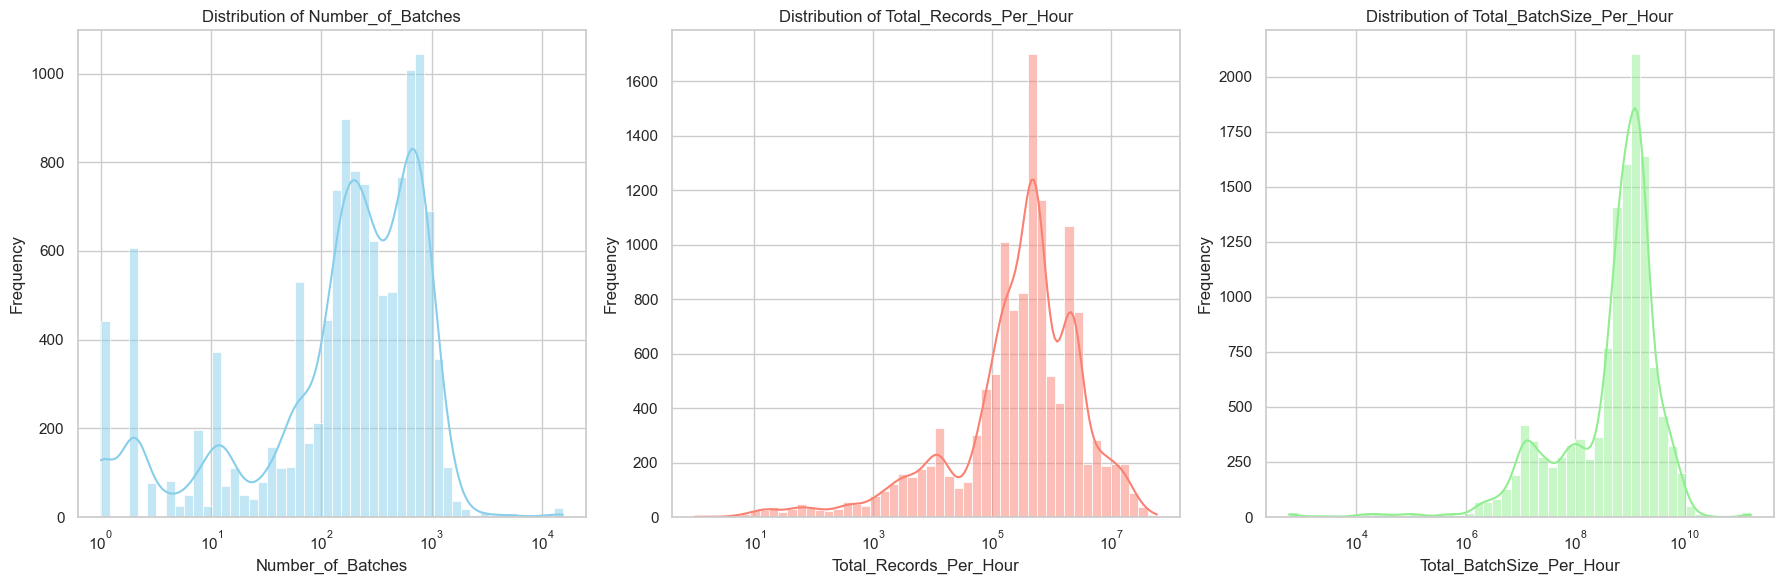

In [38]:
sns.set(style="whitegrid")

# Histogram for Number_of_Batches
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.histplot(aggregated_df['Number_of_Batches'], bins=50, kde=True, color='skyblue',log_scale=True)
plt.title('Distribution of Number_of_Batches')
plt.xlabel('Number_of_Batches')
plt.ylabel('Frequency')

# Histogram for Total_Records_Per_Hour
plt.subplot(1, 3, 2)
sns.histplot(aggregated_df['Total_Records_Per_Hour'], bins=50, kde=True, color='salmon',log_scale=True)
plt.title('Distribution of Total_Records_Per_Hour')
plt.xlabel('Total_Records_Per_Hour')
plt.ylabel('Frequency')

# Histogram for Total_BatchSize_Per_Hour
plt.subplot(1, 3, 3)
sns.histplot(aggregated_df['Total_BatchSize_Per_Hour'], bins=50, kde=True, color='lightgreen',log_scale=True)
plt.title('Distribution of Total_BatchSize_Per_Hour')
plt.xlabel('Total_BatchSize_Per_Hour')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

**Plots Analysis**:

**Total_BatchSize_Per_Hour plot:**

- The distribution shows a right-skewed pattern, with most data concentrated between 10^10 and 10^8
- There’s a visible peak near 10^9, with some smaller peaks at lower values.
- This reveals that the majority of batches have relatively large sizes, but smaller batches also exist in significant numbers.

**Total_Records_Per_Hour plot**:

- This distribution also follows a right-skewed pattern, peaking around 10^5 and 10^6, with a smoother decline after 10^6
- The density is more spread out compared to Sum_of_BatchSize, indicating high variability in record counts.
- There are smaller peaks in lower ranges, indicating some diversity in batch sizes for different data sources.

**Number_of_Batches plot**:

- This distribution shows multiple peaks at different ranges, indicating a multimodal distribution.
- The primary peak occurs around 10^3
- This spread suggests that the number of batches varies widely, with a higher frequency of smaller batches and some larger clusters.

**Gaussian Behavior:**

None of the distributions exhibit perfect Gaussian behavior, as they are highly skewed and multimodal.

# Statistical study  
Mean and Variance

In [40]:

mean_batch_size = aggregated_df['Total_BatchSize_Per_Hour'].mean()
variance_batch_size = aggregated_df['Total_BatchSize_Per_Hour'].var()

mean_records_count = aggregated_df['Total_Records_Per_Hour'].mean()
variance_records_count = aggregated_df['Total_Records_Per_Hour'].var()

mean_batches = aggregated_df['Number_of_Batches'].mean()
variance_batches = aggregated_df['Number_of_Batches'].var()

print(f"Mean of Total_BatchSize_Per_Hour: {mean_batch_size}")
print(f"Variance of Total_BatchSize_Per_Hour: {variance_batch_size}")
print('\n')
print(f"Mean of Total_Records_Per_Hour: {mean_records_count}")
print(f"Variance of Total_Records_Per_Hour: {variance_records_count}")
print('\n')
print(f"Mean of Number_of_Batches: {mean_batches}")
print(f"Variance of Number_of_Batches: {variance_batches}")


Mean of Total_BatchSize_Per_Hour: 1530298092.9716423
Variance of Total_BatchSize_Per_Hour: 4.054883950237048e+19


Mean of Total_Records_Per_Hour: 1622901.7643346838
Variance of Total_Records_Per_Hour: 15174552983330.08


Mean of Number_of_Batches: 381.1882206294796
Variance of Number_of_Batches: 452691.9385476396


**This result confirms the Plot analysis above.** 

In [41]:
aggregated_df.set_index('Date_Hour', inplace=True)


# Visualizing features over time

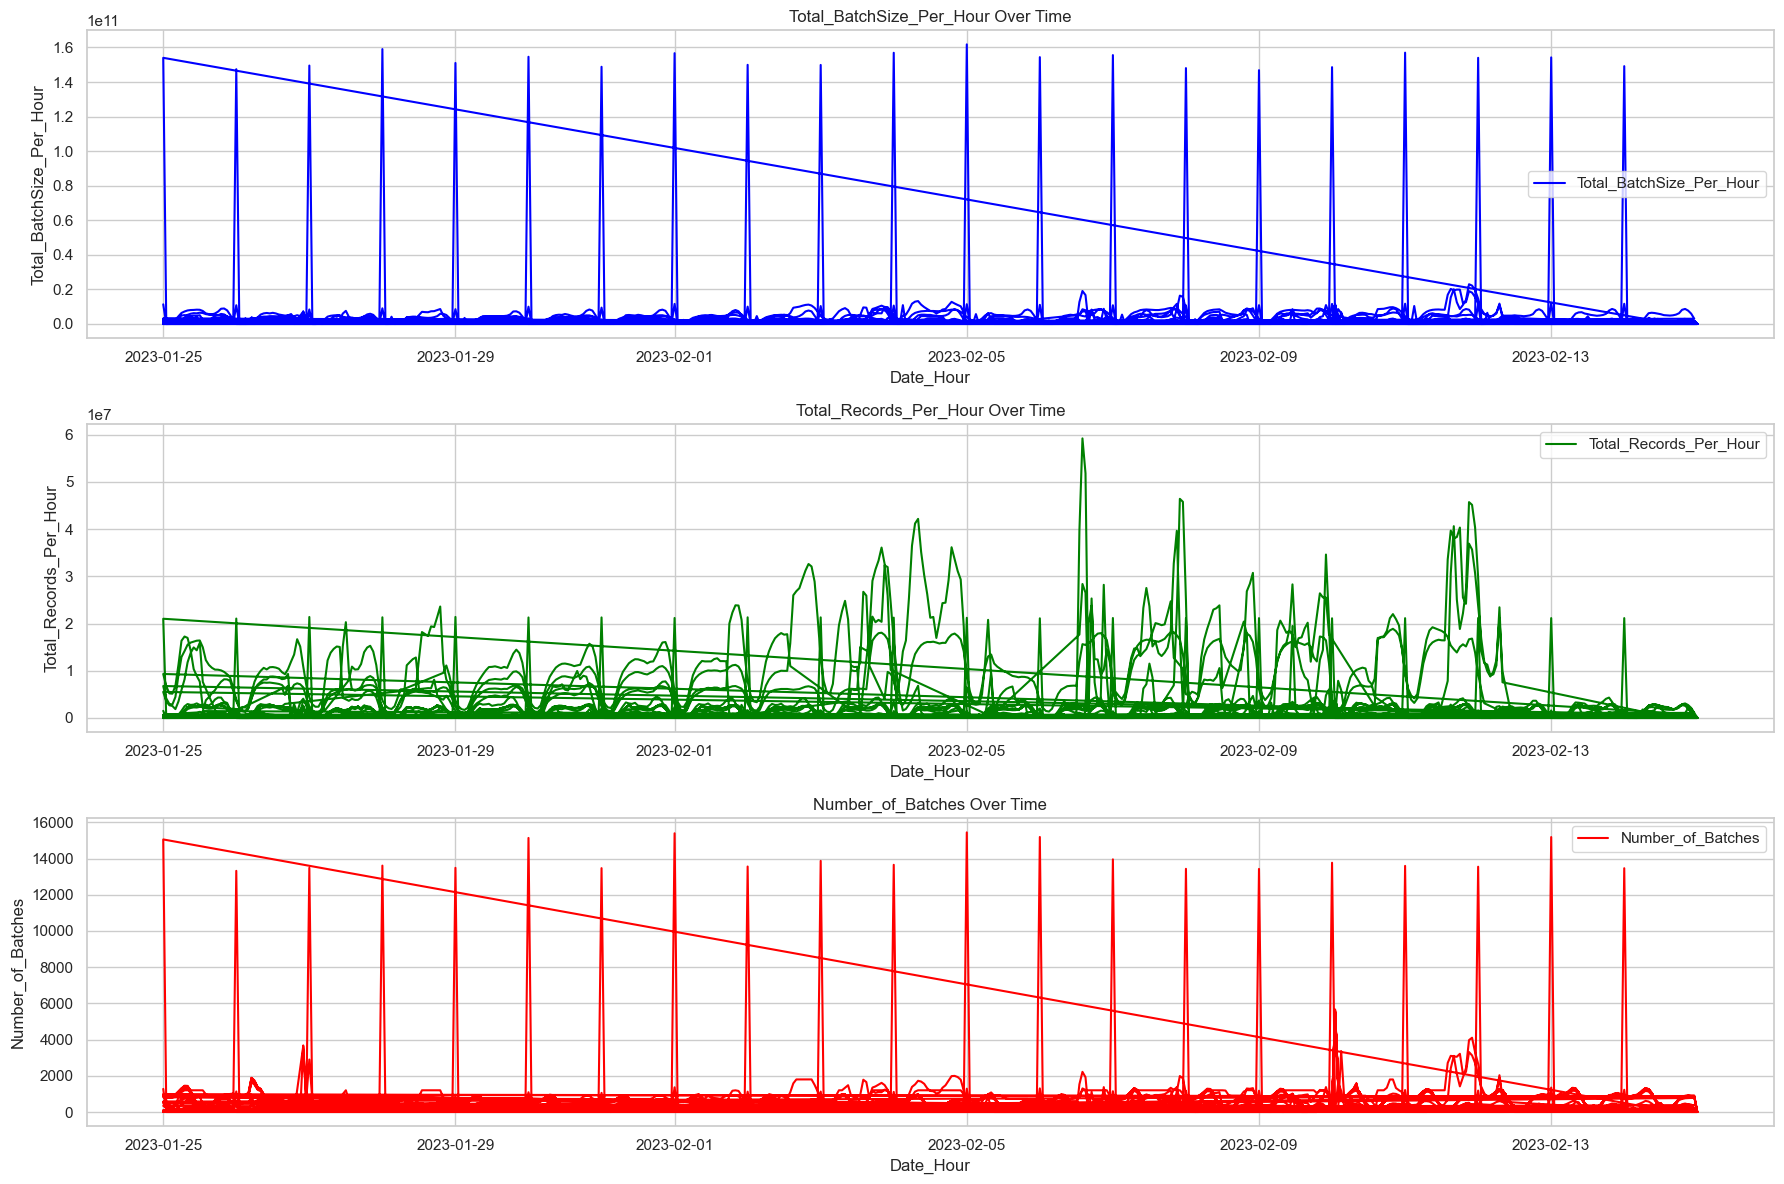

In [42]:

plt.figure(figsize=(18, 12))

# Plot Total_BatchSize_Per_Hour over time
plt.subplot(3, 1, 1)
plt.plot(aggregated_df.index, aggregated_df['Total_BatchSize_Per_Hour'], color='blue', label='Total_BatchSize_Per_Hour')
plt.xlabel('Date_Hour')
plt.ylabel('Total_BatchSize_Per_Hour')
plt.title('Total_BatchSize_Per_Hour Over Time')
plt.legend()

# Plot Total_Records_Per_Hour over time
plt.subplot(3, 1, 2)
plt.plot(aggregated_df.index, aggregated_df['Total_Records_Per_Hour'], color='green', label='Total_Records_Per_Hour')
plt.xlabel('Date_Hour')
plt.ylabel('Total_Records_Per_Hour')
plt.title('Total_Records_Per_Hour Over Time')
plt.legend()

# Plot Number_of_Batches over time
plt.subplot(3, 1, 3)
plt.plot(aggregated_df.index, aggregated_df['Number_of_Batches'], color='red', label='Number_of_Batches')
plt.xlabel('Date_Hour')
plt.ylabel('Number_of_Batches')
plt.title('Number_of_Batches Over Time')
plt.legend()

plt.tight_layout()
plt.show()


**Plot Analysis**:
- These plots represent the distribution of features over time for all data source nodes, where each data source is represented by a unique line that reflects its behavior pattern. 
- The plots of **Number_of_Batches** and **Total_BatchSize_per_hour** show that most data sources have a nearly similar distribution, with only minor differences, and reveal a certain seasonality in the overall view. We also observe some lines decaying, indicating that certain nodes are deteriorating and the data flow is approaching zero.
- However, the plot of **TotalRecord_per_hour** shows a significantly different behavior over time for each data source.

*For a clearer analysis, more visualizations should be created.*

# Visualizing Features by DataSourceId

C:\Users\ThinkBook\AppData\Local\Temp\ipykernel_20484\3882668888.py:27: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


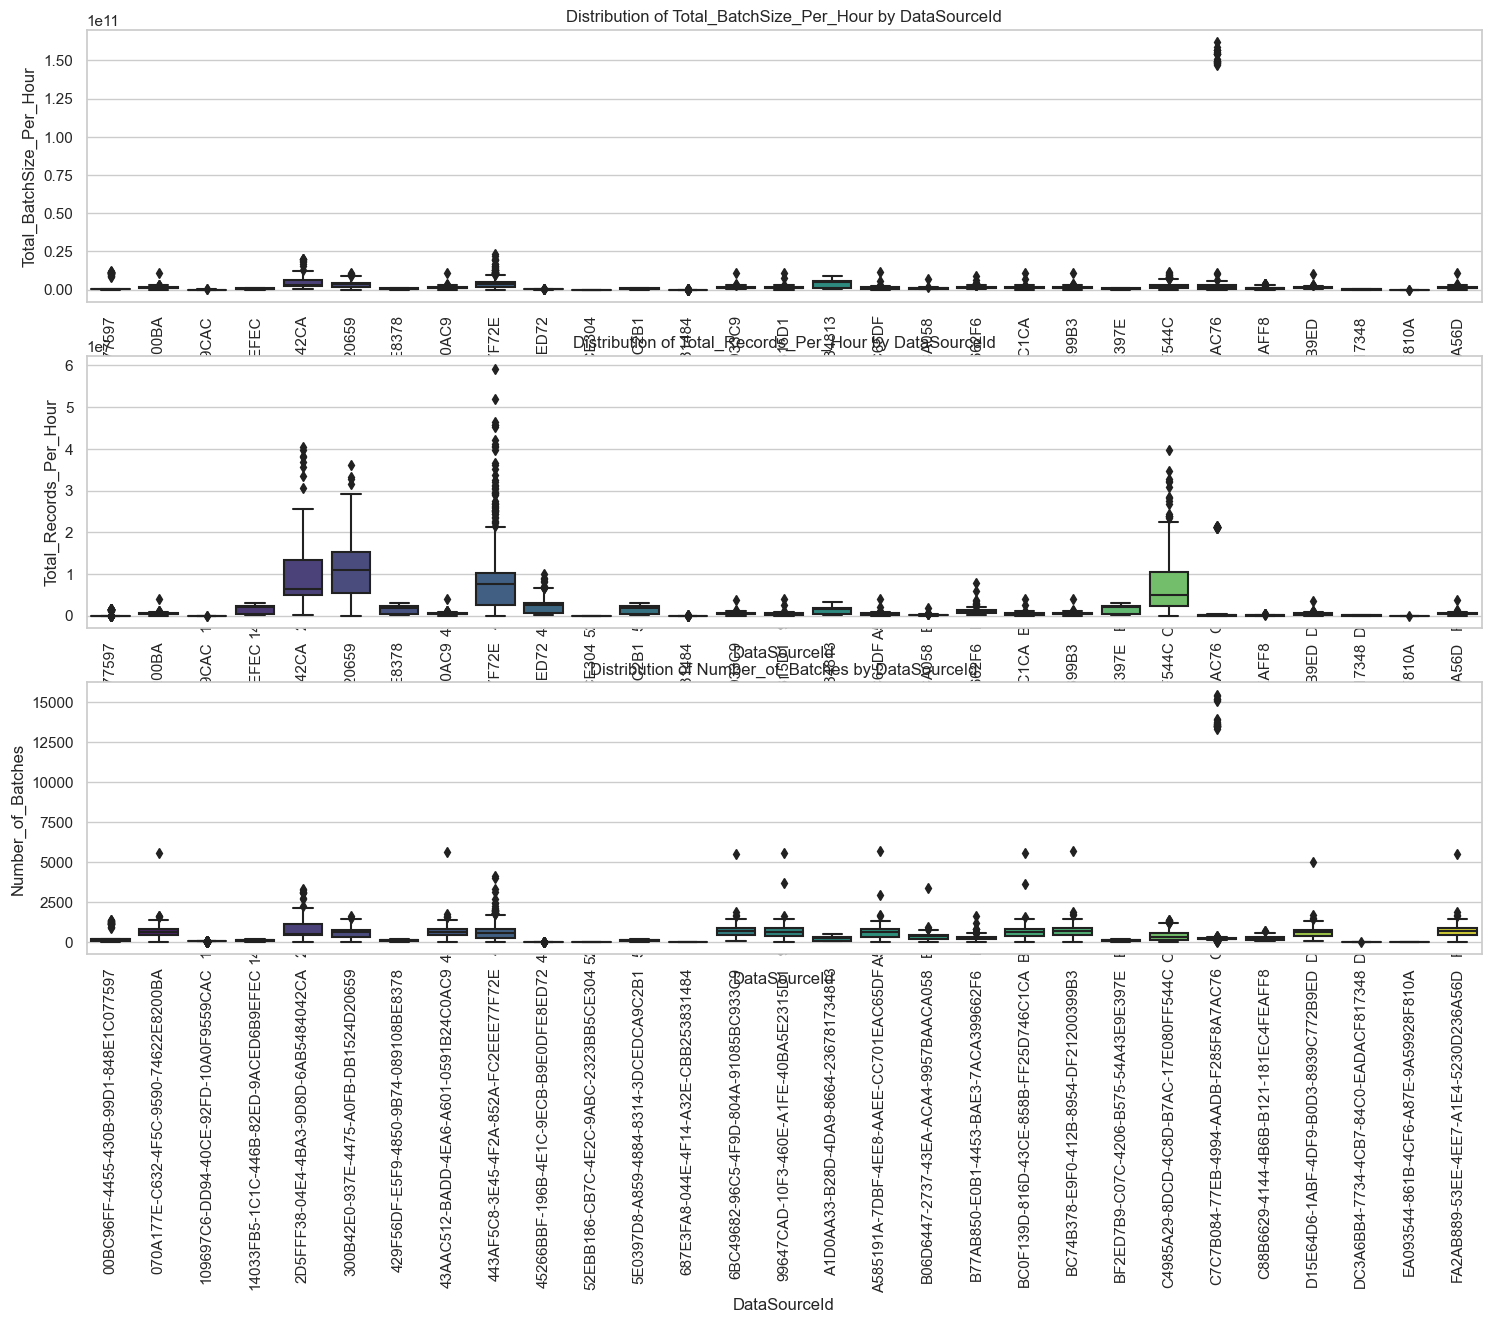

In [43]:
plt.figure(figsize=(18, 12))

# Plot Total_BatchSize_Per_Hour by DataSourceId
plt.subplot(3, 1, 1)
sns.boxplot(data=aggregated_df, x='DataSourceId', y='Total_BatchSize_Per_Hour', palette='viridis')
plt.xlabel('DataSourceId')
plt.ylabel('Total_BatchSize_Per_Hour')
plt.title('Distribution of Total_BatchSize_Per_Hour by DataSourceId')
plt.xticks(rotation=90)

# Plot Total_Records_Per_Hour by DataSourceId
plt.subplot(3, 1, 2)
sns.boxplot(data=aggregated_df, x='DataSourceId', y='Total_Records_Per_Hour', palette='viridis')
plt.xlabel('DataSourceId')
plt.ylabel('Total_Records_Per_Hour')
plt.title('Distribution of Total_Records_Per_Hour by DataSourceId')
plt.xticks(rotation=90)

# Plot Number_of_Batches by DataSourceId
plt.subplot(3, 1, 3)
sns.boxplot(data=aggregated_df, x='DataSourceId', y='Number_of_Batches', palette='viridis')
plt.xlabel('DataSourceId')
plt.ylabel('Number_of_Batches')
plt.title('Distribution of Number_of_Batches by DataSourceId')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


**Plot Analysis**:
</br>
Based on these boxplots:
- Number_of_Batches and Total_BatchSize_per_hour generally have narrow boxes, indicating a smaller spread in their data. This suggests that these features have relatively consistent values across time. However, TotalRecord_per_hour shows, for example, four large boxes, indicating that the corresponding data sources experience a wide range of record counts, suggesting variability in their data flow.

- The overall view indicates that some nodes are not very active, as their features are represented by very narrow boxes close to zero. In contrast, other nodes have relatively narrow boxes but with more significant values, suggesting a stable flow of data.

- Points outside the whiskers reflect outliers in some data sources. These outliers are relevant for anomaly detection and should be considered in forecasting models, as they may indicate unusual or unexpected events.

# EDA for time series

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose


## Decomposition in additive and multiplicative model

In [45]:
period = 24  # This is for daily seasonality in hourly data

### Overall plot

##### Additive model

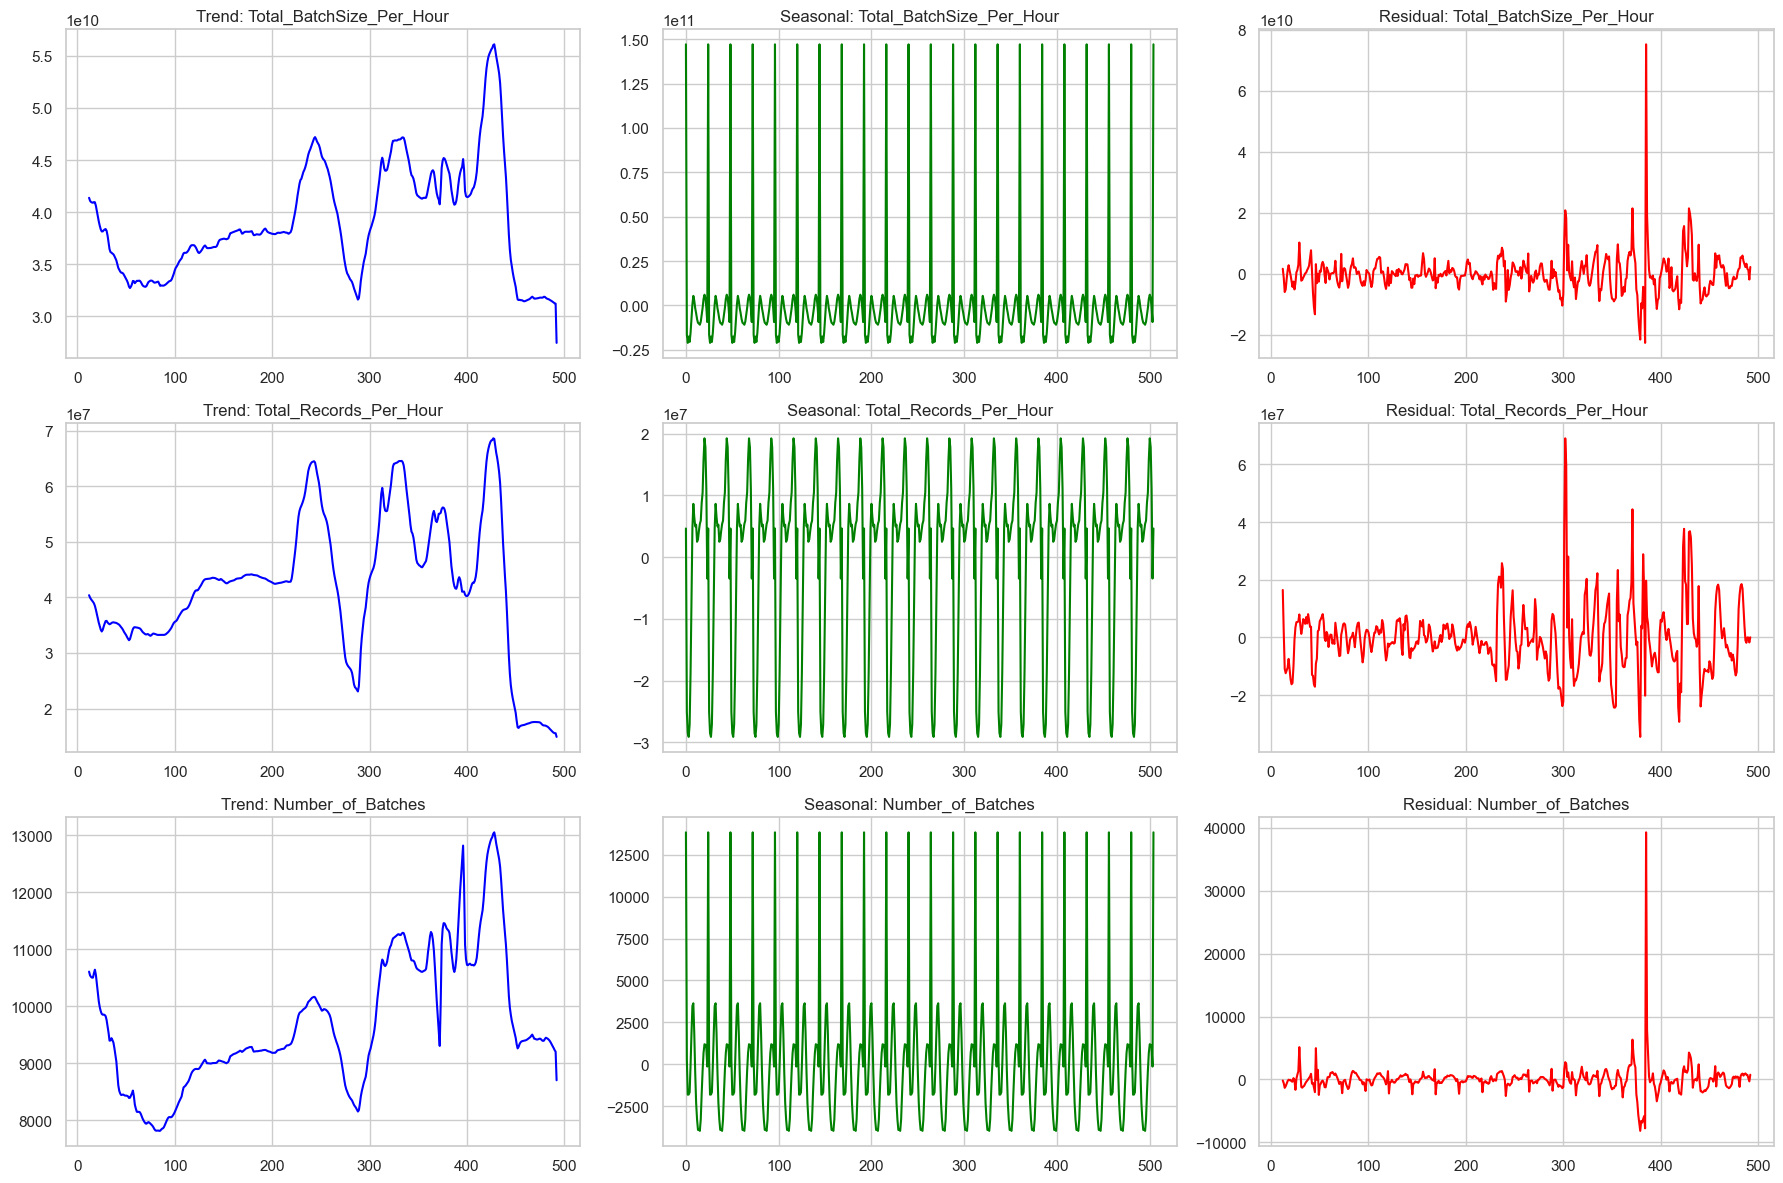

In [48]:
# Group by Date_Hour for an overall plot
grouped_by_hour = aggregated_df.groupby('Date_Hour').agg({
    'Total_BatchSize_Per_Hour': 'sum',
    'Total_Records_Per_Hour': 'sum',
    'Number_of_Batches': 'sum'
}).reset_index()

# Decompose each feature using additive model
decompose_batch_size = seasonal_decompose(grouped_by_hour['Total_BatchSize_Per_Hour'], model='additive', period=period)
decompose_records_count = seasonal_decompose(grouped_by_hour['Total_Records_Per_Hour'], model='additive', period=period)
decompose_batches = seasonal_decompose(grouped_by_hour['Number_of_Batches'], model='additive', period=period)

# Plot in a 3x3 grid
plt.figure(figsize=(18, 12))

# Row 1: Total_BatchSize_Per_Hour
plt.subplot(3, 3, 1)
plt.plot(decompose_batch_size.trend, color='blue')
plt.title('Trend: Total_BatchSize_Per_Hour')

plt.subplot(3, 3, 2)
plt.plot(decompose_batch_size.seasonal, color='green')
plt.title('Seasonal: Total_BatchSize_Per_Hour')

plt.subplot(3, 3, 3)
plt.plot(decompose_batch_size.resid, color='red')
plt.title('Residual: Total_BatchSize_Per_Hour')

# Row 2: Total_Records_Per_Hour
plt.subplot(3, 3, 4)
plt.plot(decompose_records_count.trend, color='blue')
plt.title('Trend: Total_Records_Per_Hour')

plt.subplot(3, 3, 5)
plt.plot(decompose_records_count.seasonal, color='green')
plt.title('Seasonal: Total_Records_Per_Hour')

plt.subplot(3, 3, 6)
plt.plot(decompose_records_count.resid, color='red')
plt.title('Residual: Total_Records_Per_Hour')

# Row 3: Number_of_Batches
plt.subplot(3, 3, 7)
plt.plot(decompose_batches.trend, color='blue')
plt.title('Trend: Number_of_Batches')

plt.subplot(3, 3, 8)
plt.plot(decompose_batches.seasonal, color='green')
plt.title('Seasonal: Number_of_Batches')

plt.subplot(3, 3, 9)
plt.plot(decompose_batches.resid, color='red')
plt.title('Residual: Number_of_Batches')

plt.tight_layout()
plt.show()


#### Multiplicative Model

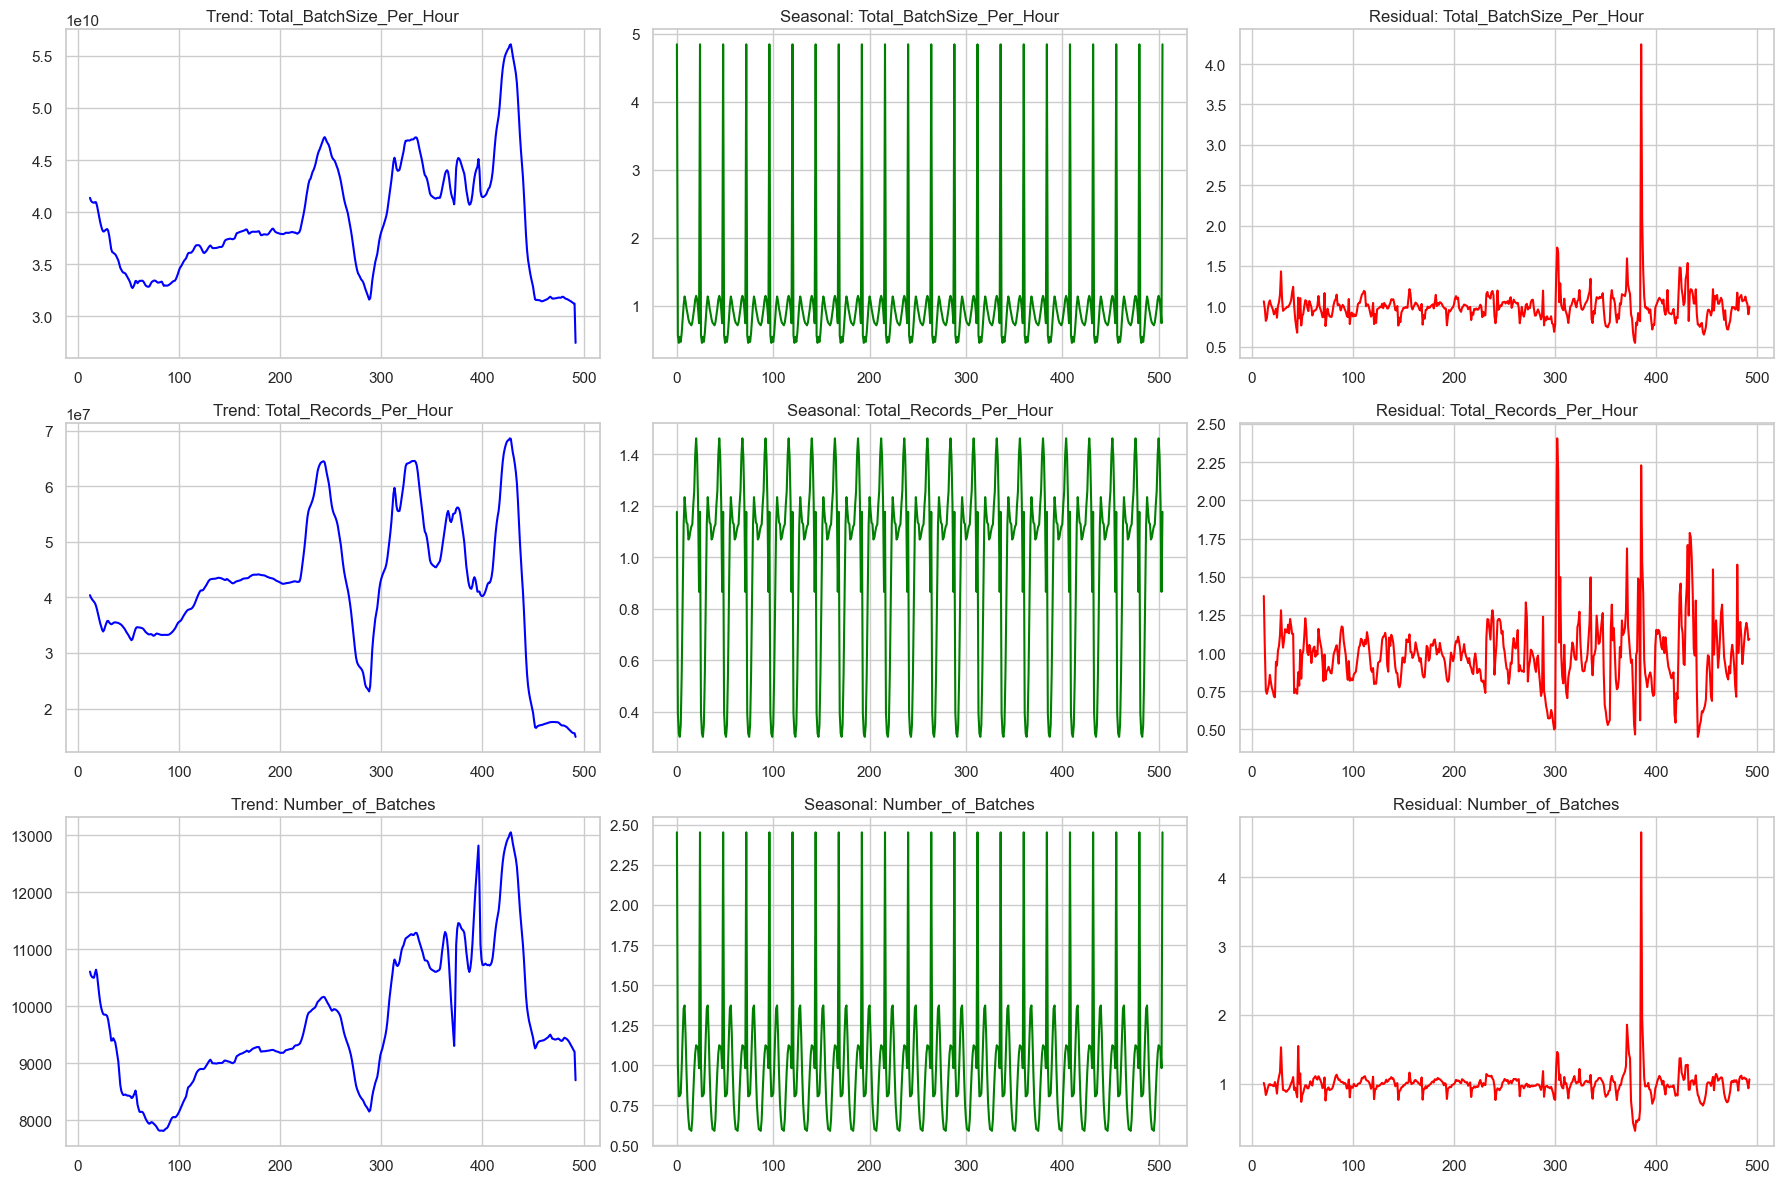

In [49]:
decompose_batch_size = seasonal_decompose(grouped_by_hour['Total_BatchSize_Per_Hour'], model='multiplicative', period=period)
decompose_records_count = seasonal_decompose(grouped_by_hour['Total_Records_Per_Hour'], model='multiplicative', period=period)
decompose_batches = seasonal_decompose(grouped_by_hour['Number_of_Batches'], model='multiplicative', period=period)

# Plot in a 3x3 grid
plt.figure(figsize=(18, 12))

# Row 1: Total_BatchSize_Per_Hour
plt.subplot(3, 3, 1)
plt.plot(decompose_batch_size.trend, color='blue')
plt.title('Trend: Total_BatchSize_Per_Hour')

plt.subplot(3, 3, 2)
plt.plot(decompose_batch_size.seasonal, color='green')
plt.title('Seasonal: Total_BatchSize_Per_Hour')

plt.subplot(3, 3, 3)
plt.plot(decompose_batch_size.resid, color='red')
plt.title('Residual: Total_BatchSize_Per_Hour')

# Row 2: Total_Records_Per_Hour
plt.subplot(3, 3, 4)
plt.plot(decompose_records_count.trend, color='blue')
plt.title('Trend: Total_Records_Per_Hour')

plt.subplot(3, 3, 5)
plt.plot(decompose_records_count.seasonal, color='green')
plt.title('Seasonal: Total_Records_Per_Hour')

plt.subplot(3, 3, 6)
plt.plot(decompose_records_count.resid, color='red')
plt.title('Residual: Total_Records_Per_Hour')

# Row 3: Number_of_Batches
plt.subplot(3, 3, 7)
plt.plot(decompose_batches.trend, color='blue')
plt.title('Trend: Number_of_Batches')

plt.subplot(3, 3, 8)
plt.plot(decompose_batches.seasonal, color='green')
plt.title('Seasonal: Number_of_Batches')

plt.subplot(3, 3, 9)
plt.plot(decompose_batches.resid, color='red')
plt.title('Residual: Number_of_Batches')

plt.tight_layout()
plt.show()


**Additive Model** seems like the best choice, because we have:
- A fluctuating trend (no clear exponential growth or decline), which suggests that an additive model is more appropriate. The multiplicative model is typically used when both the trend and seasonality grow or shrink proportionally (seasonality increases when the trend increases). Since the trend here is not showing exponential growth or decline, the additive model is a better choice.
- Clear seasonality 
- Residuals centered around zero in general (with some outliers), indicating that the model is capturing most of the signal.

#### Each DataSource node Alone:



plot fo 00BC96FF-4455-430B-99D1-848E1C077597:




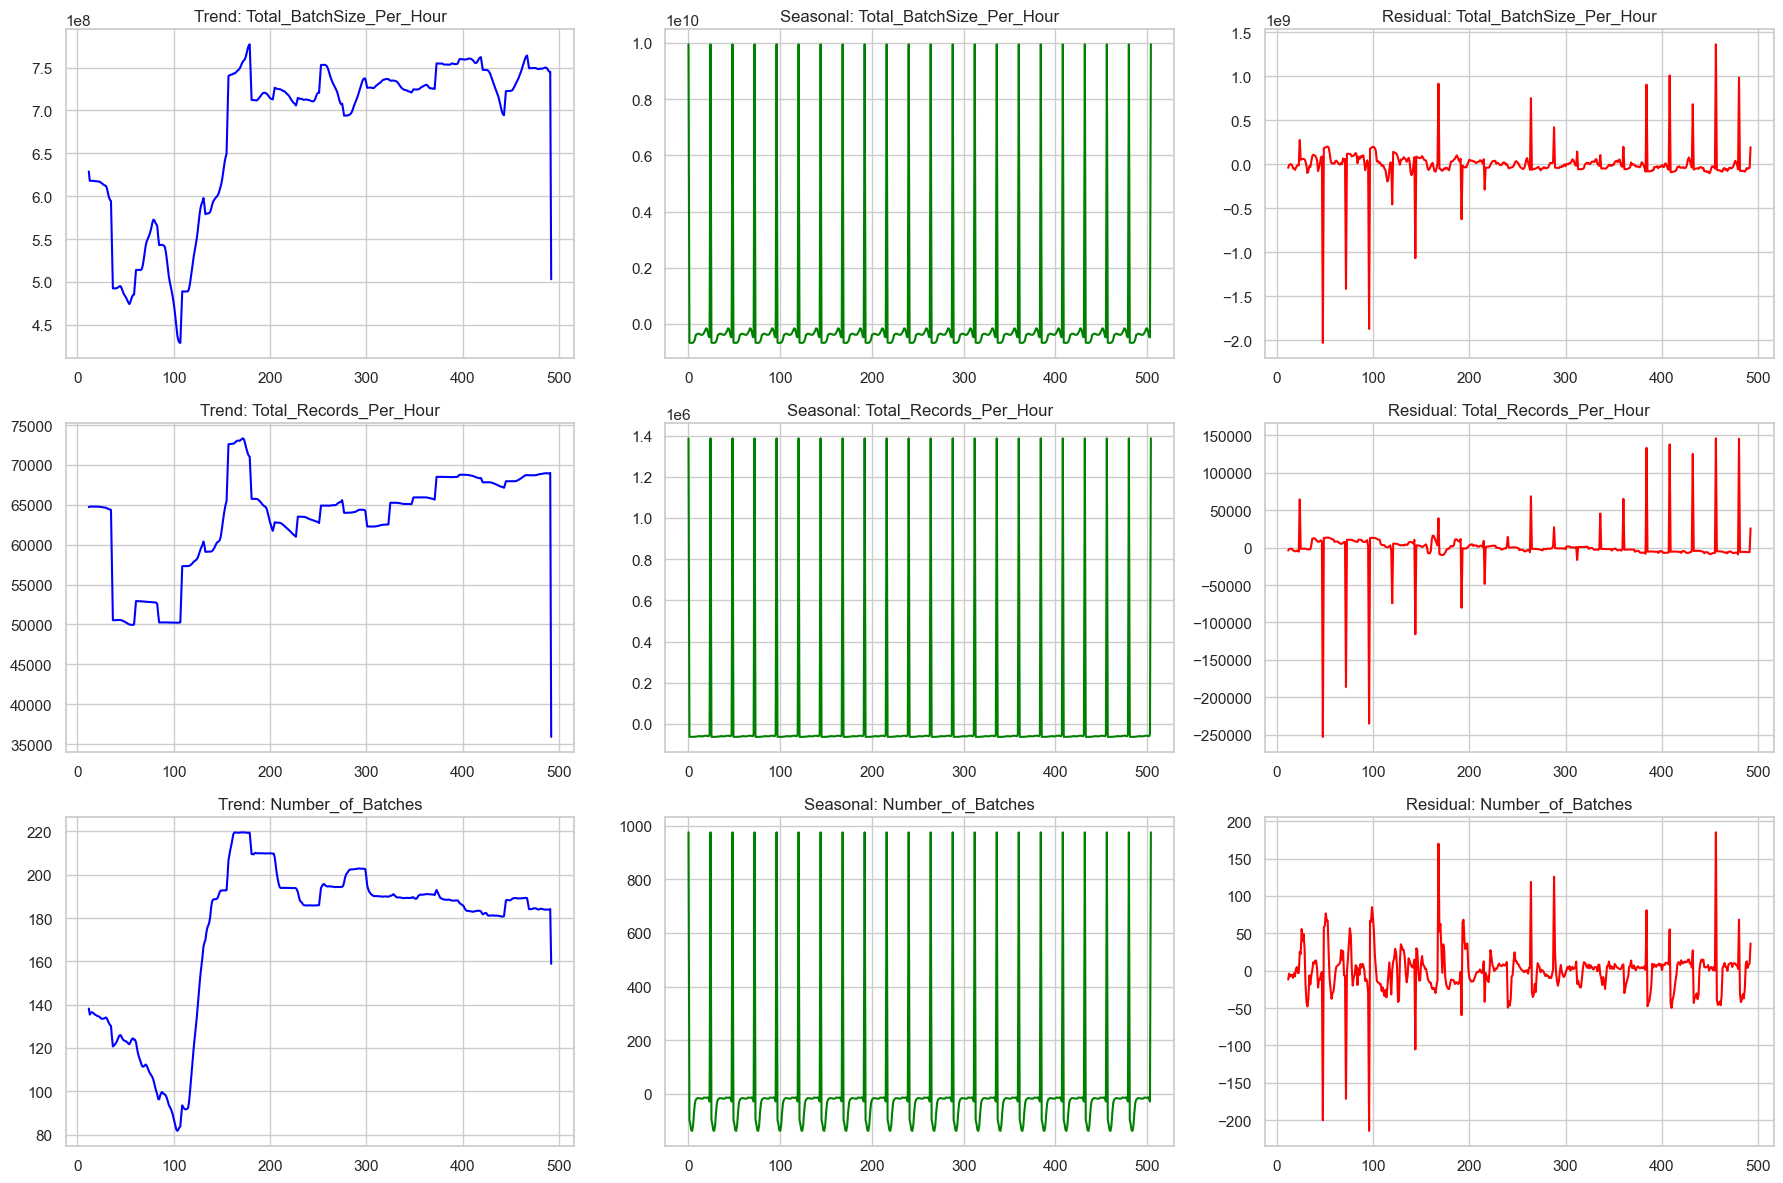





plot fo 070A177E-C632-4F5C-9590-74622E8200BA:




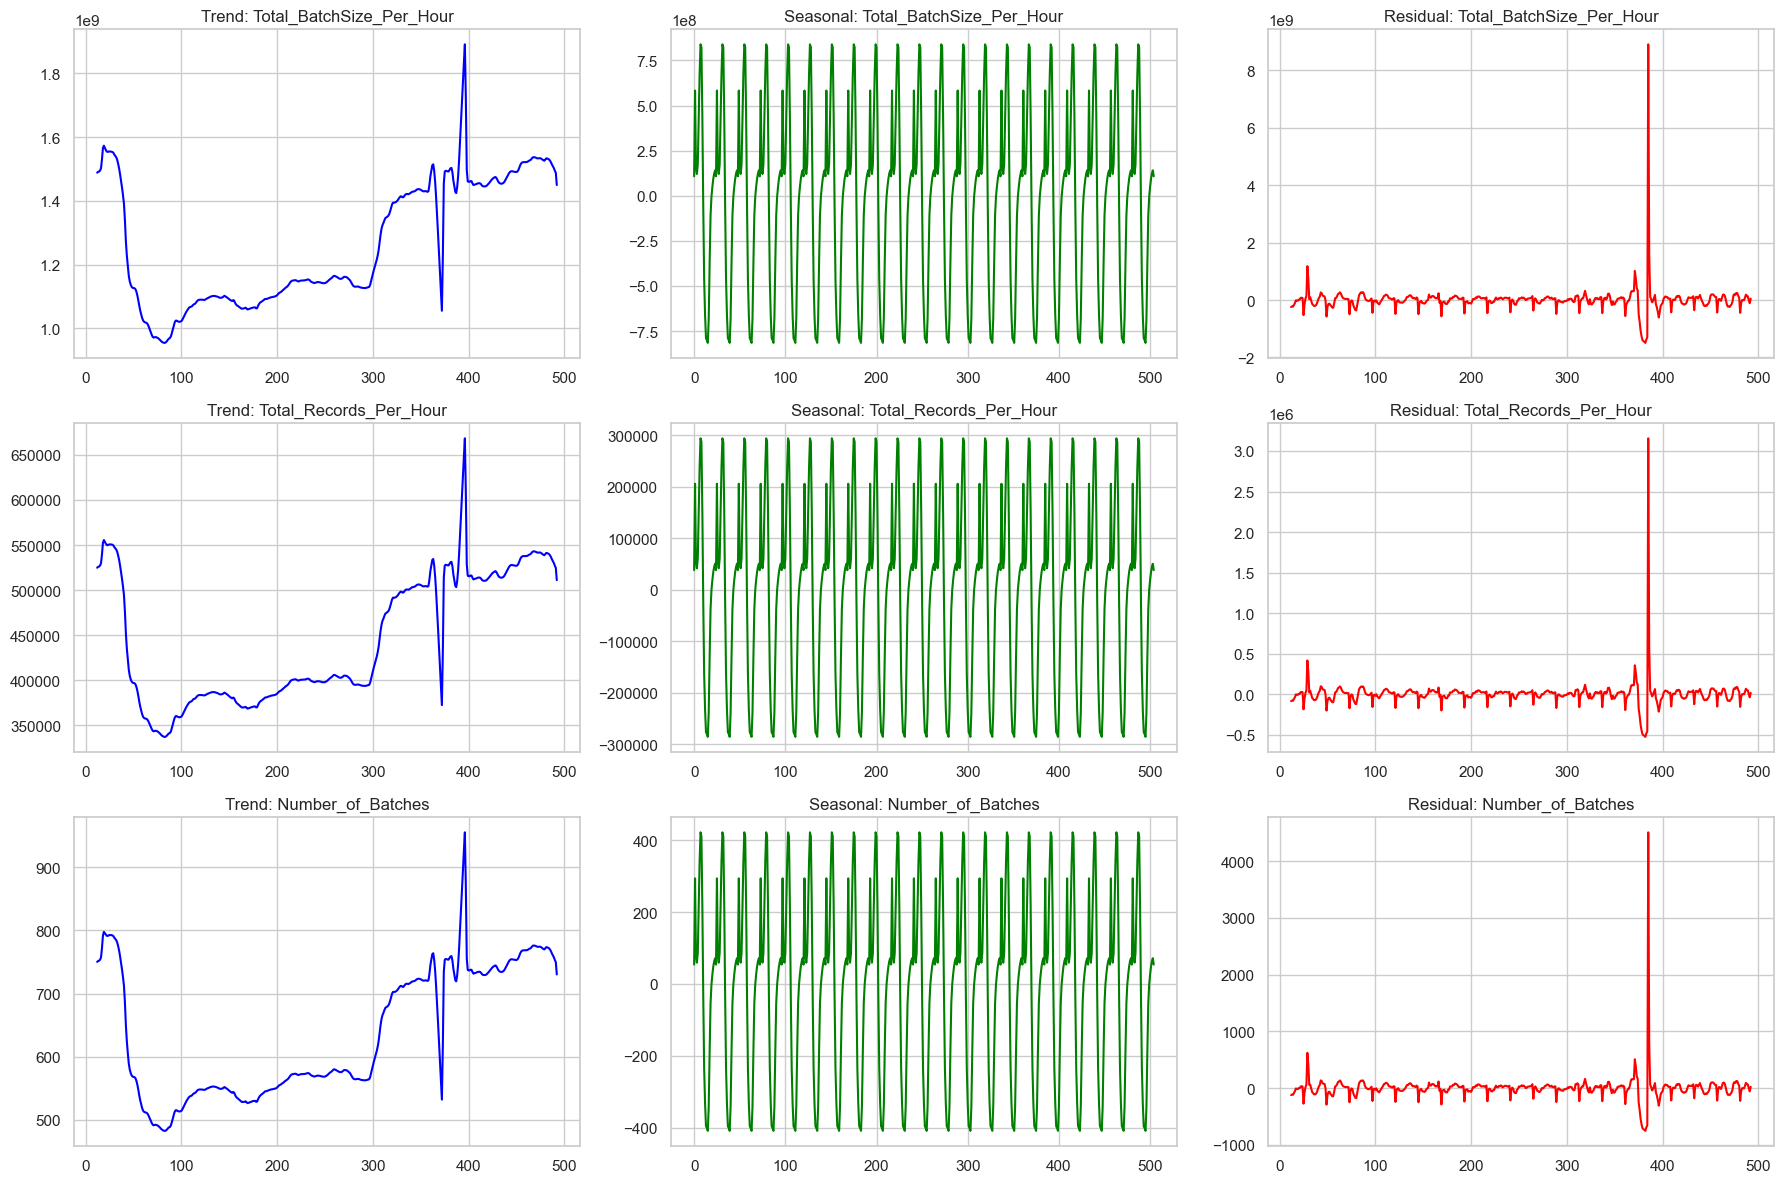





plot fo 109697C6-DD94-40CE-92FD-10A0F9559CAC:




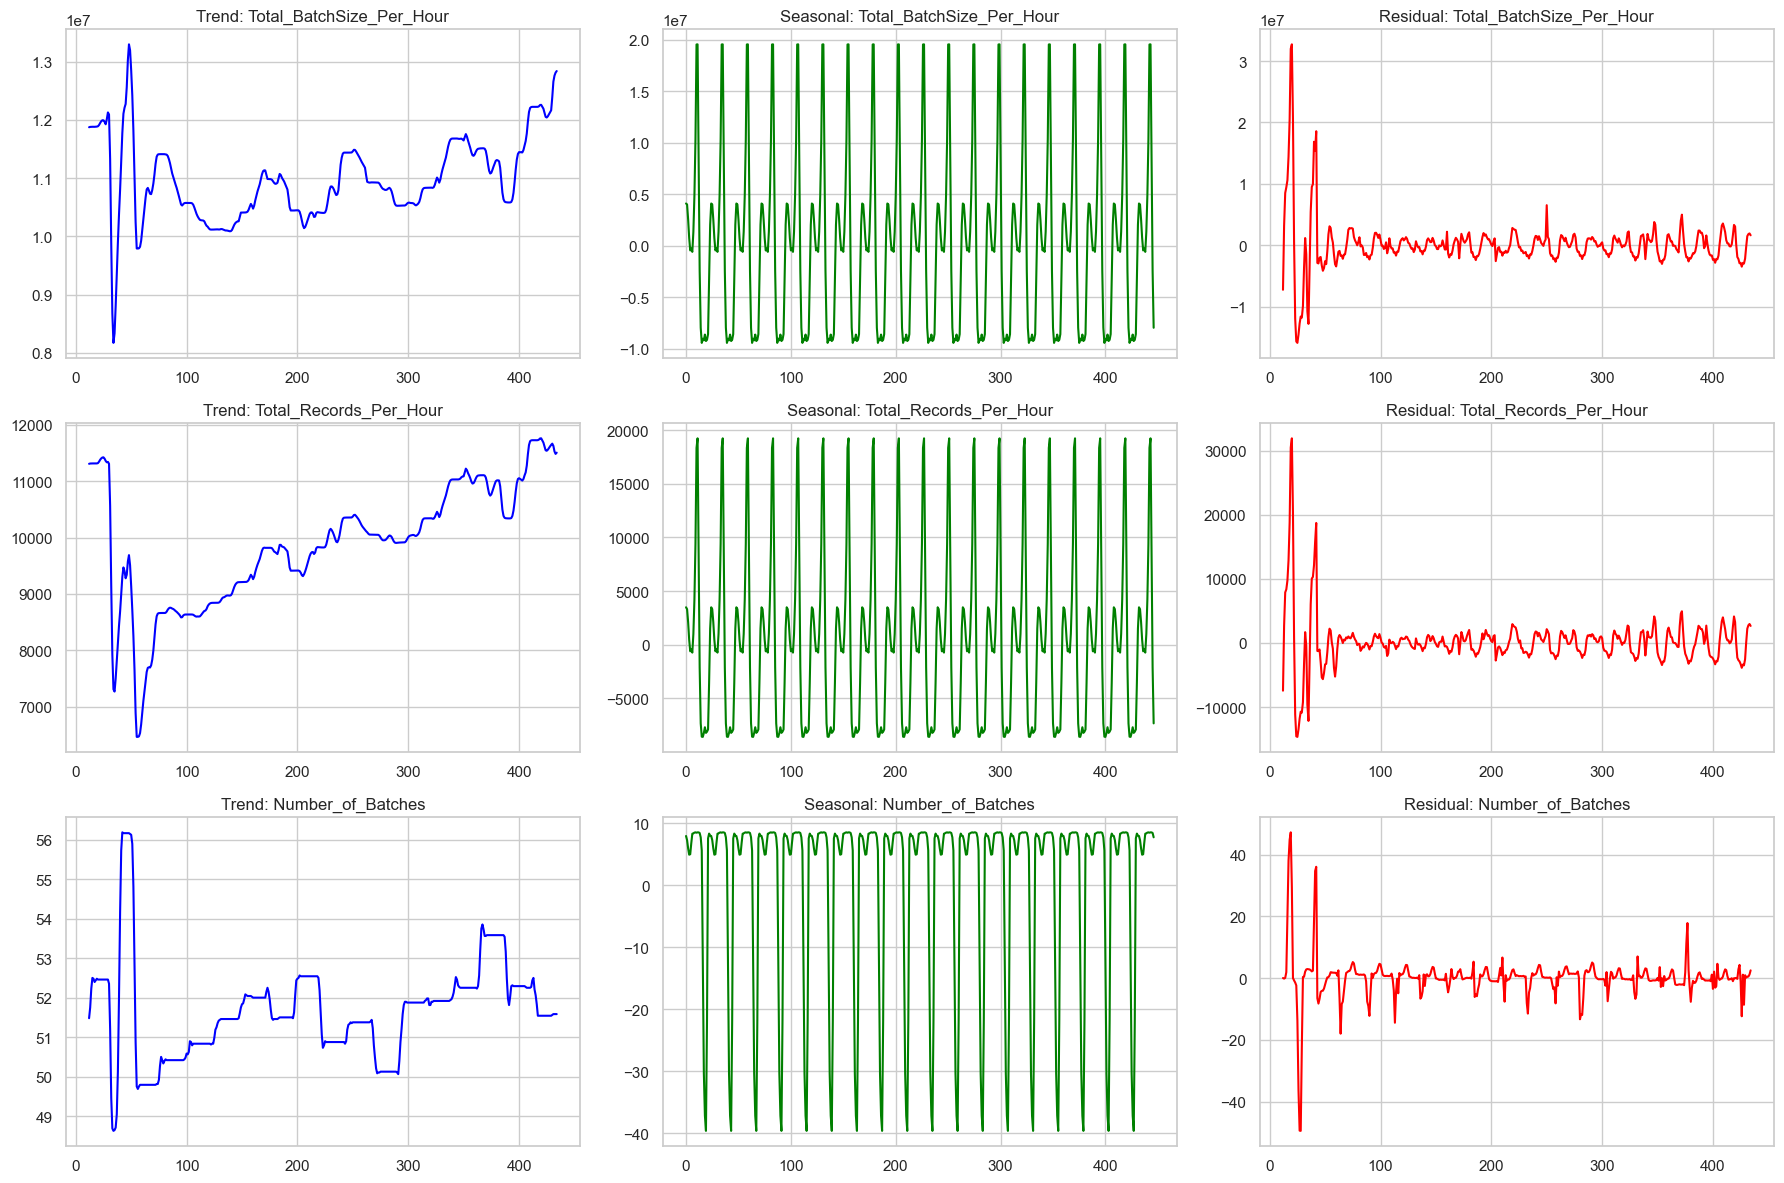





plot fo 14033FB5-1C1C-446B-82ED-9ACED6B9EFEC:




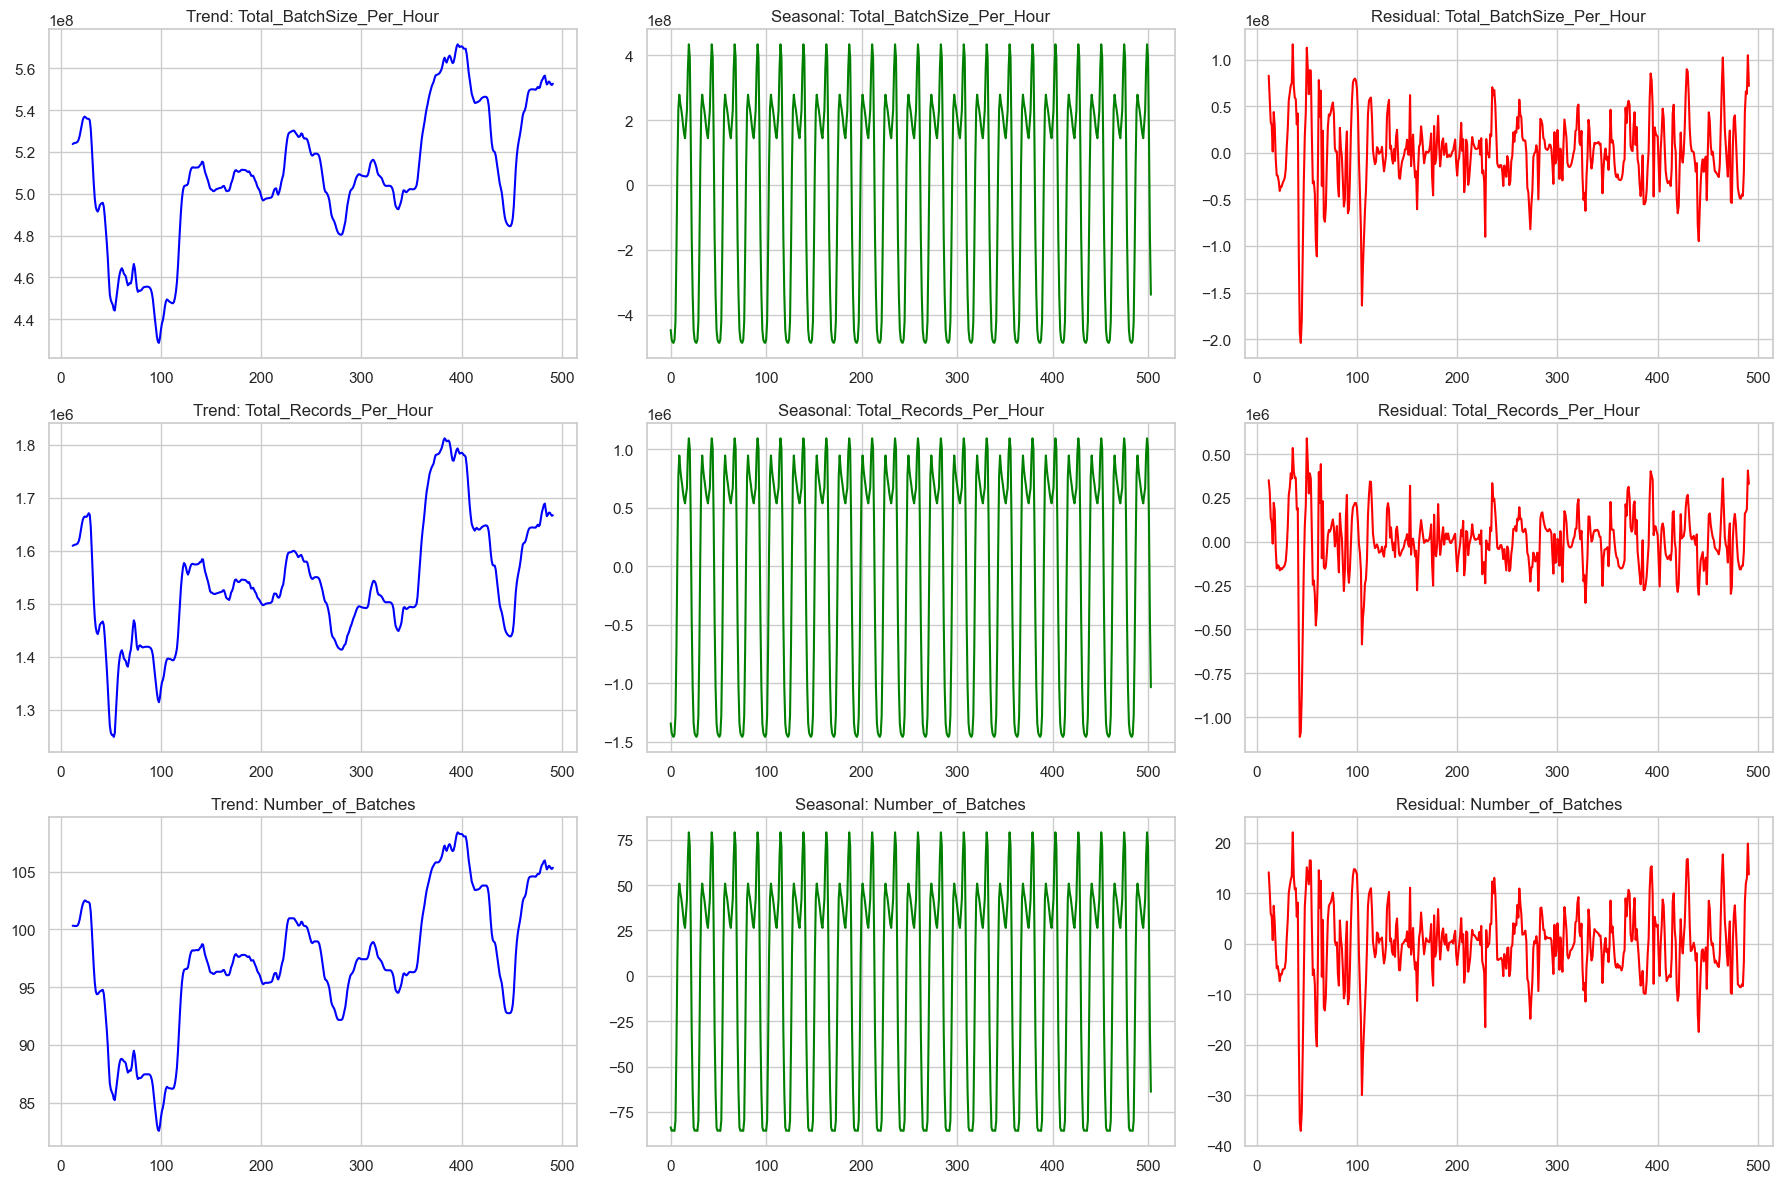





plot fo 2D5FFF38-04E4-4BA3-9D8D-6AB5484042CA:




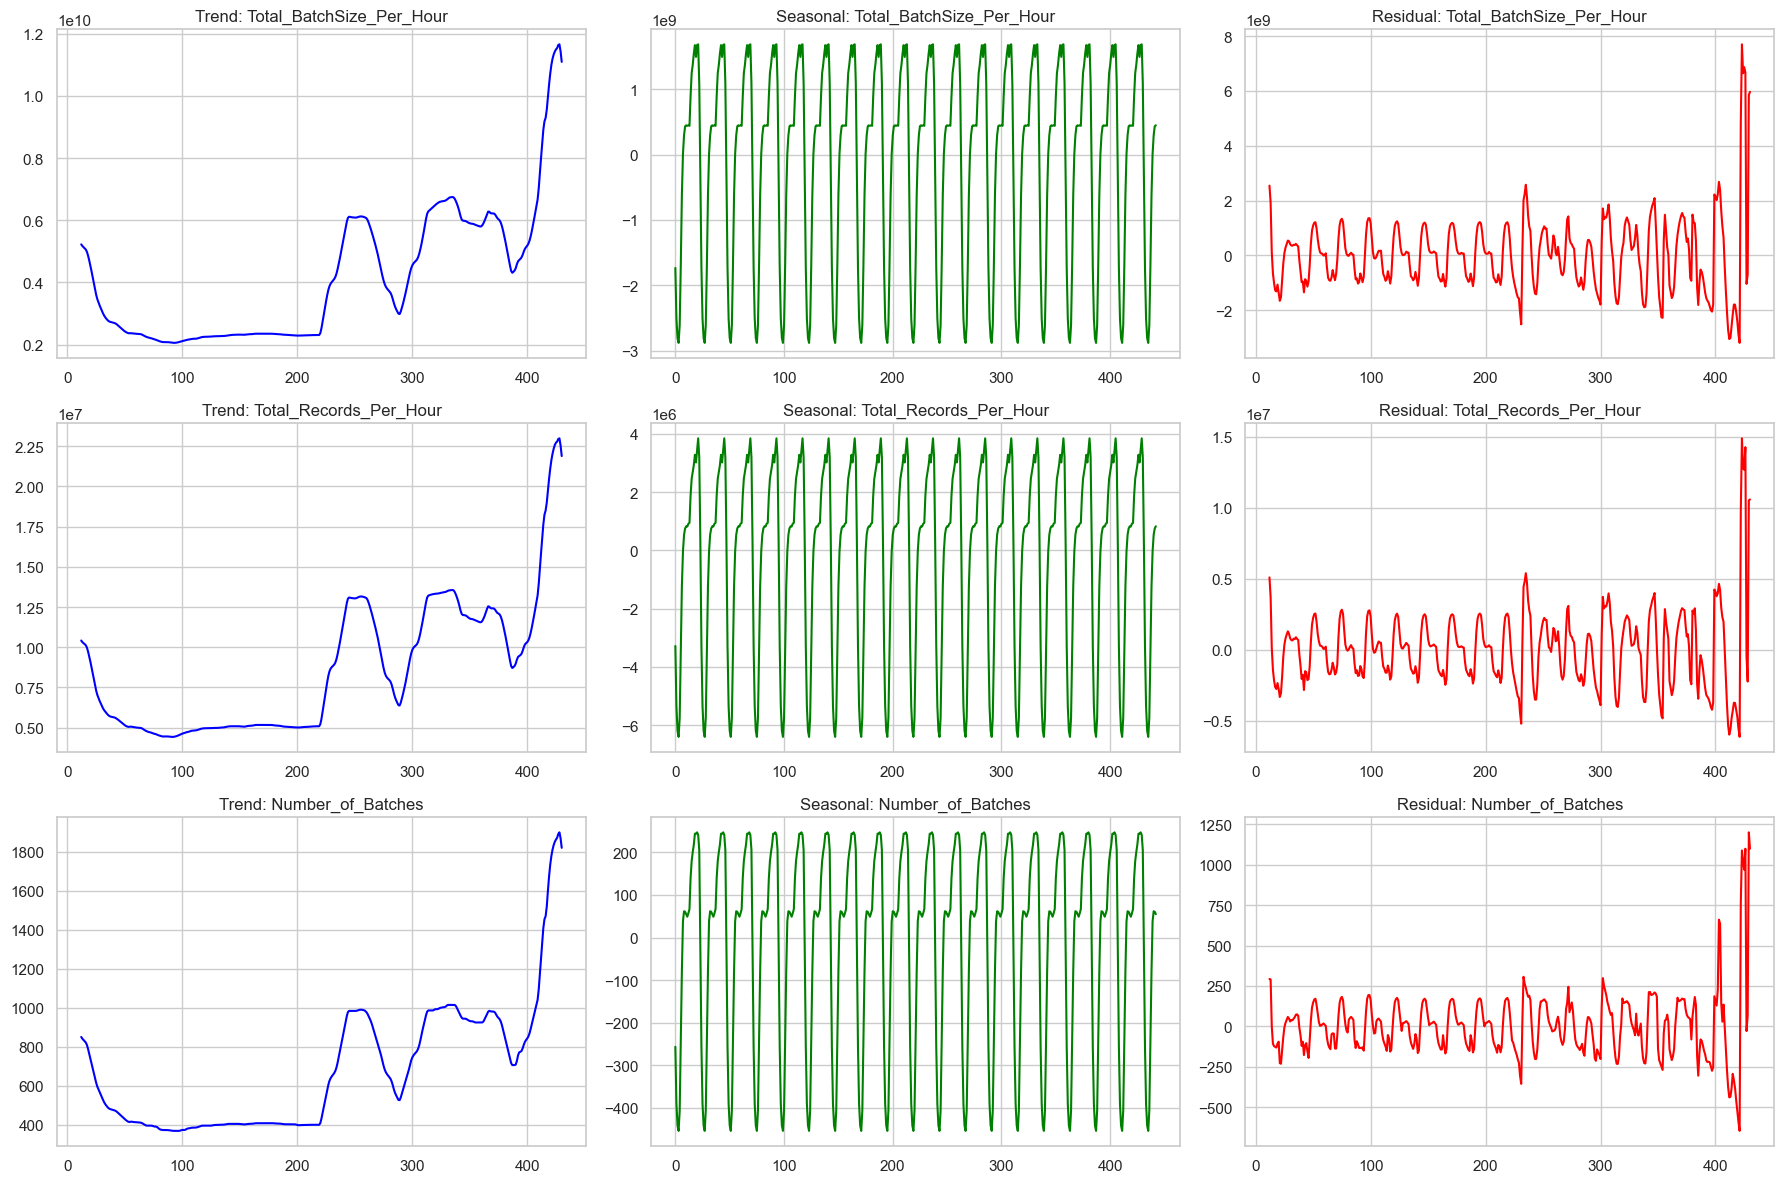





plot fo 300B42E0-937E-4475-A0FB-DB1524D20659:




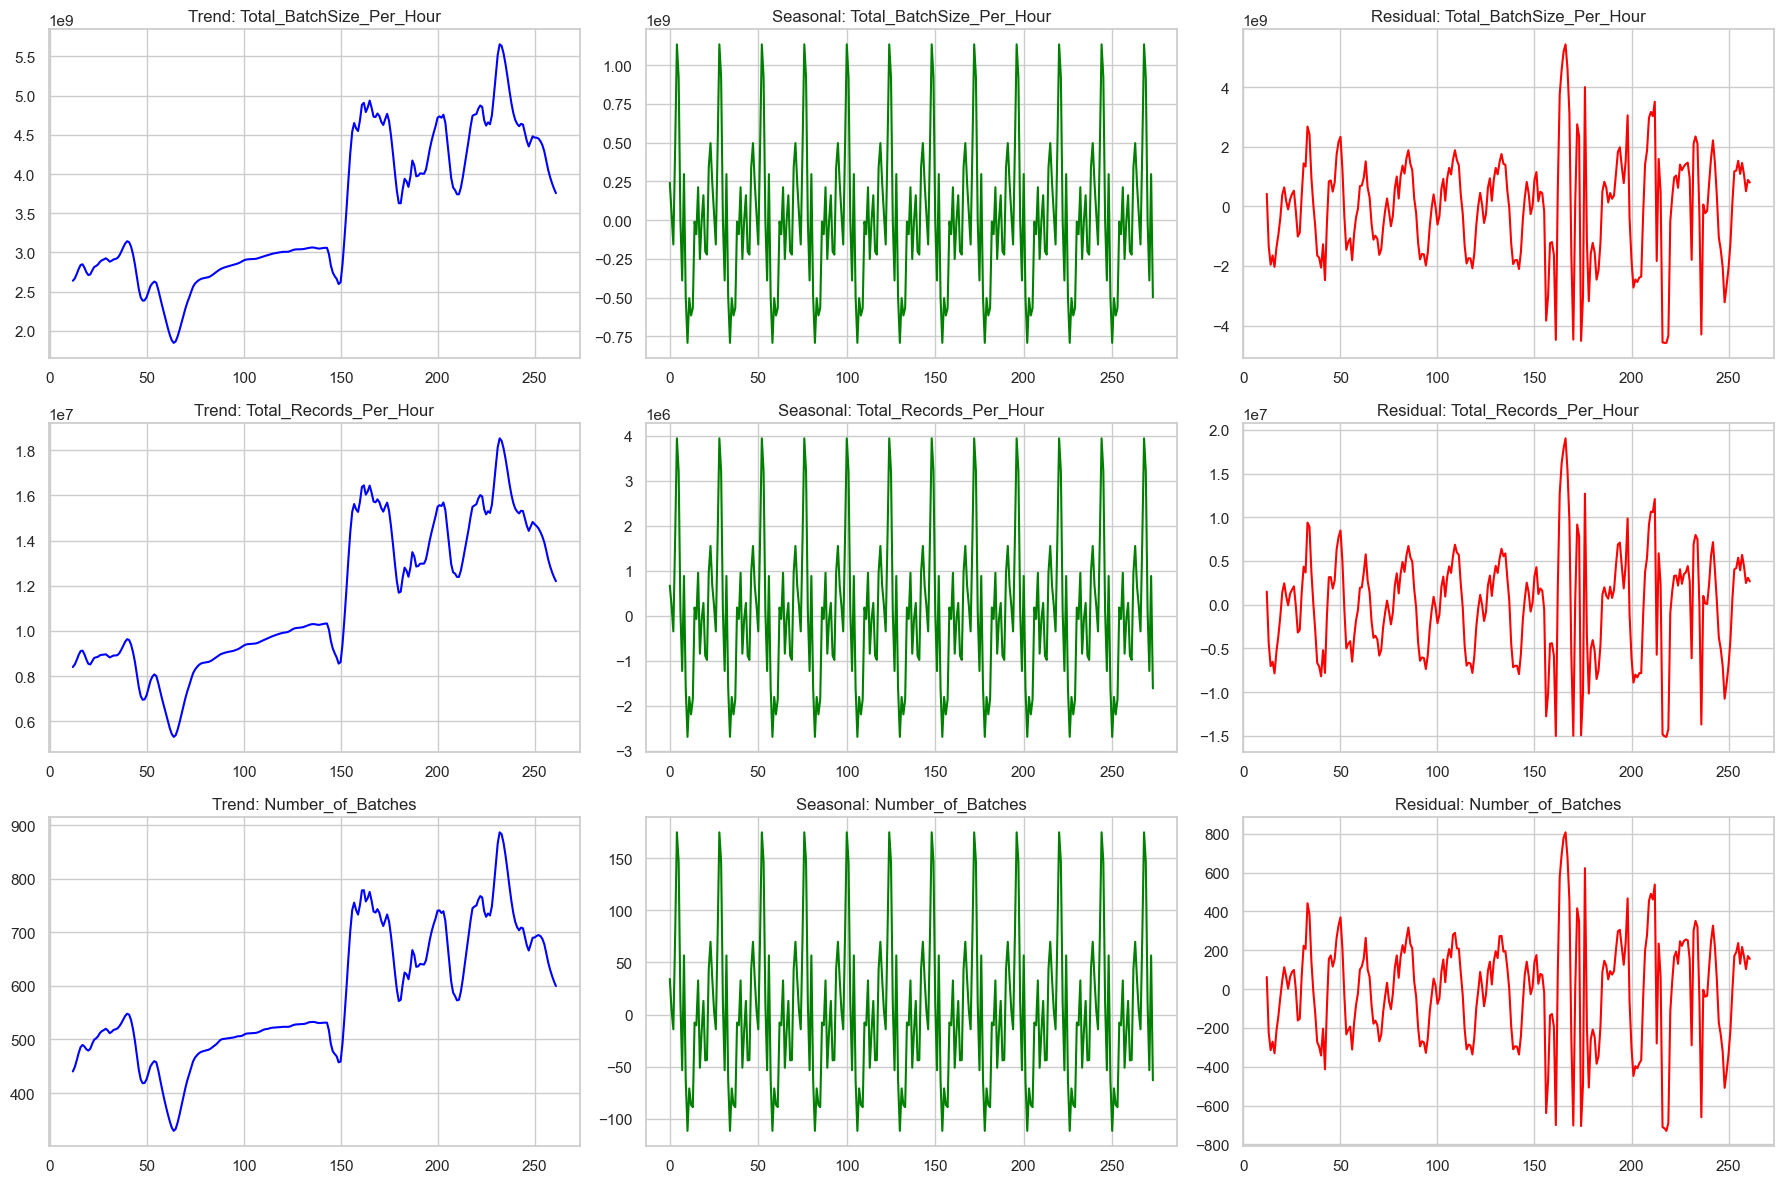





plot fo 429F56DF-E5F9-4850-9B74-089108BE8378:




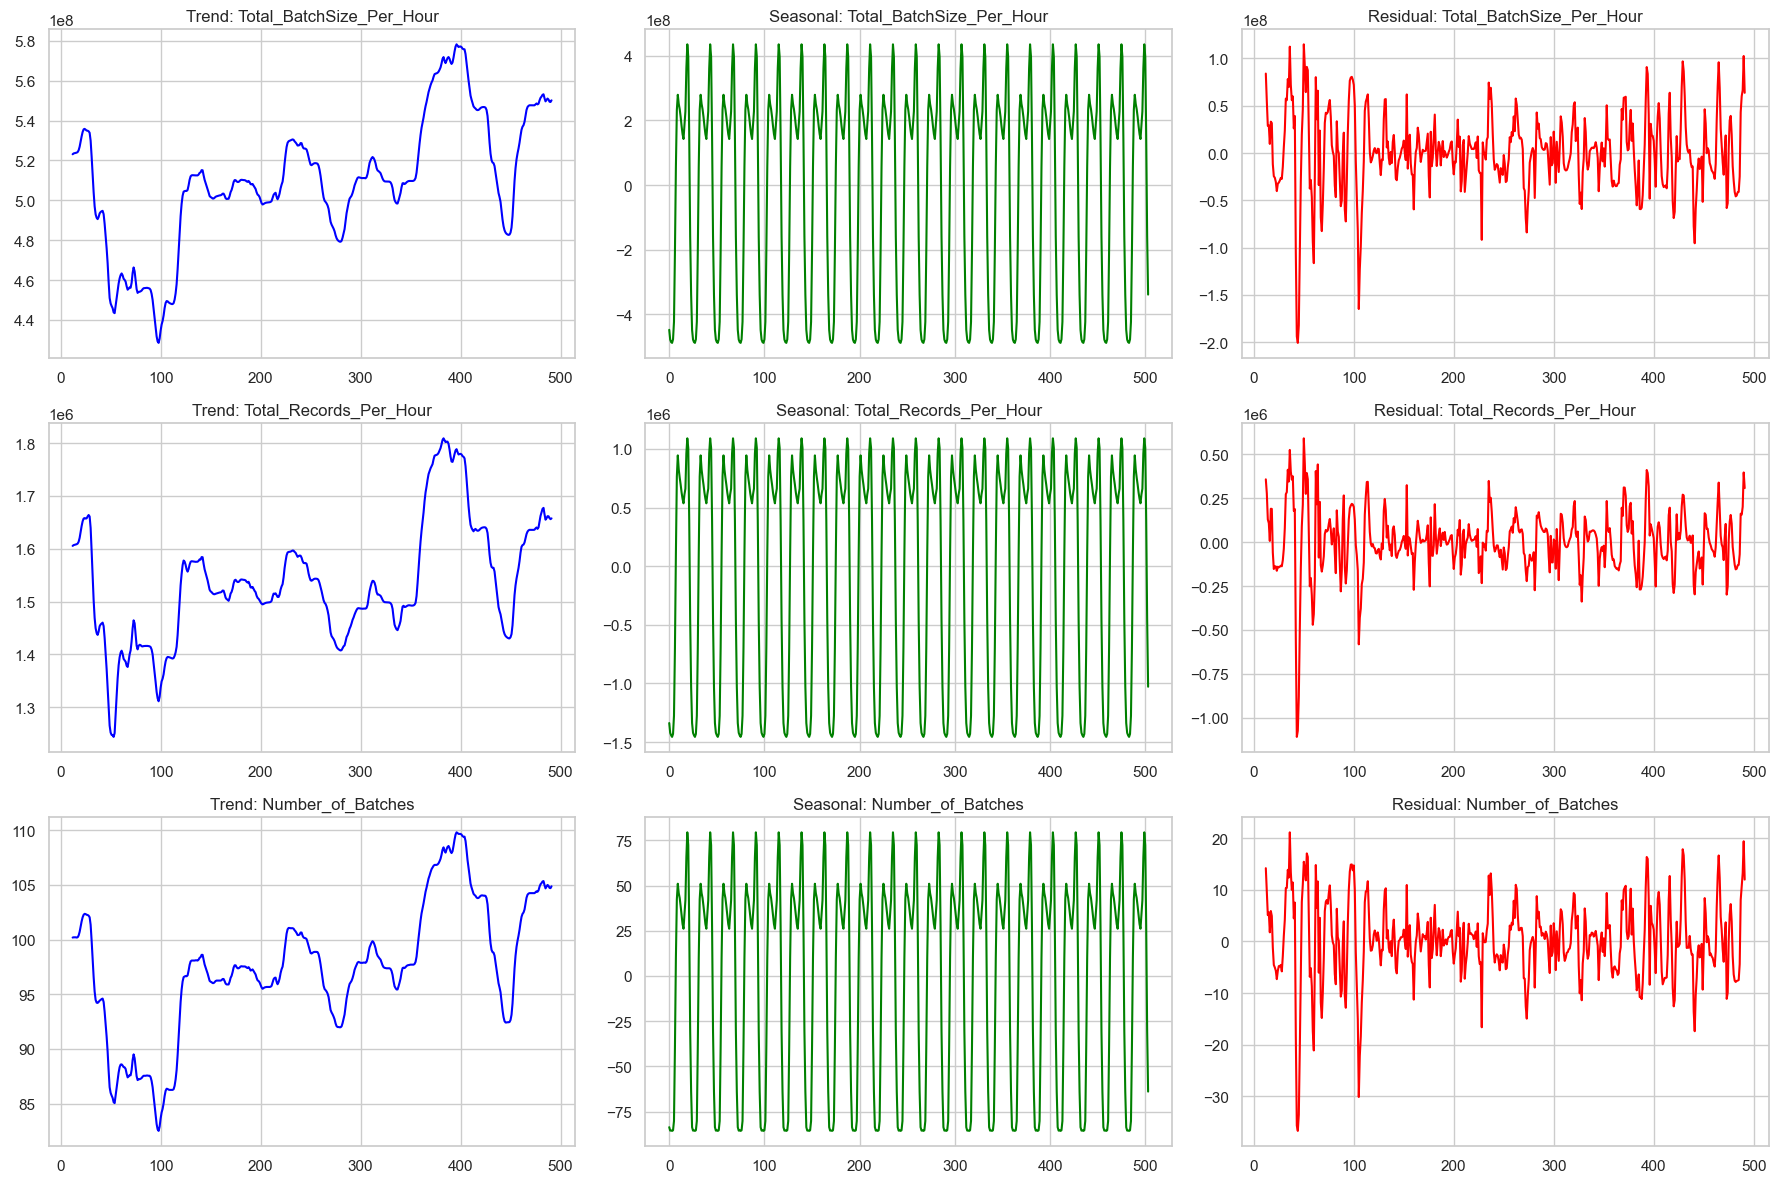





plot fo 43AAC512-BADD-4EA6-A601-0591B24C0AC9:




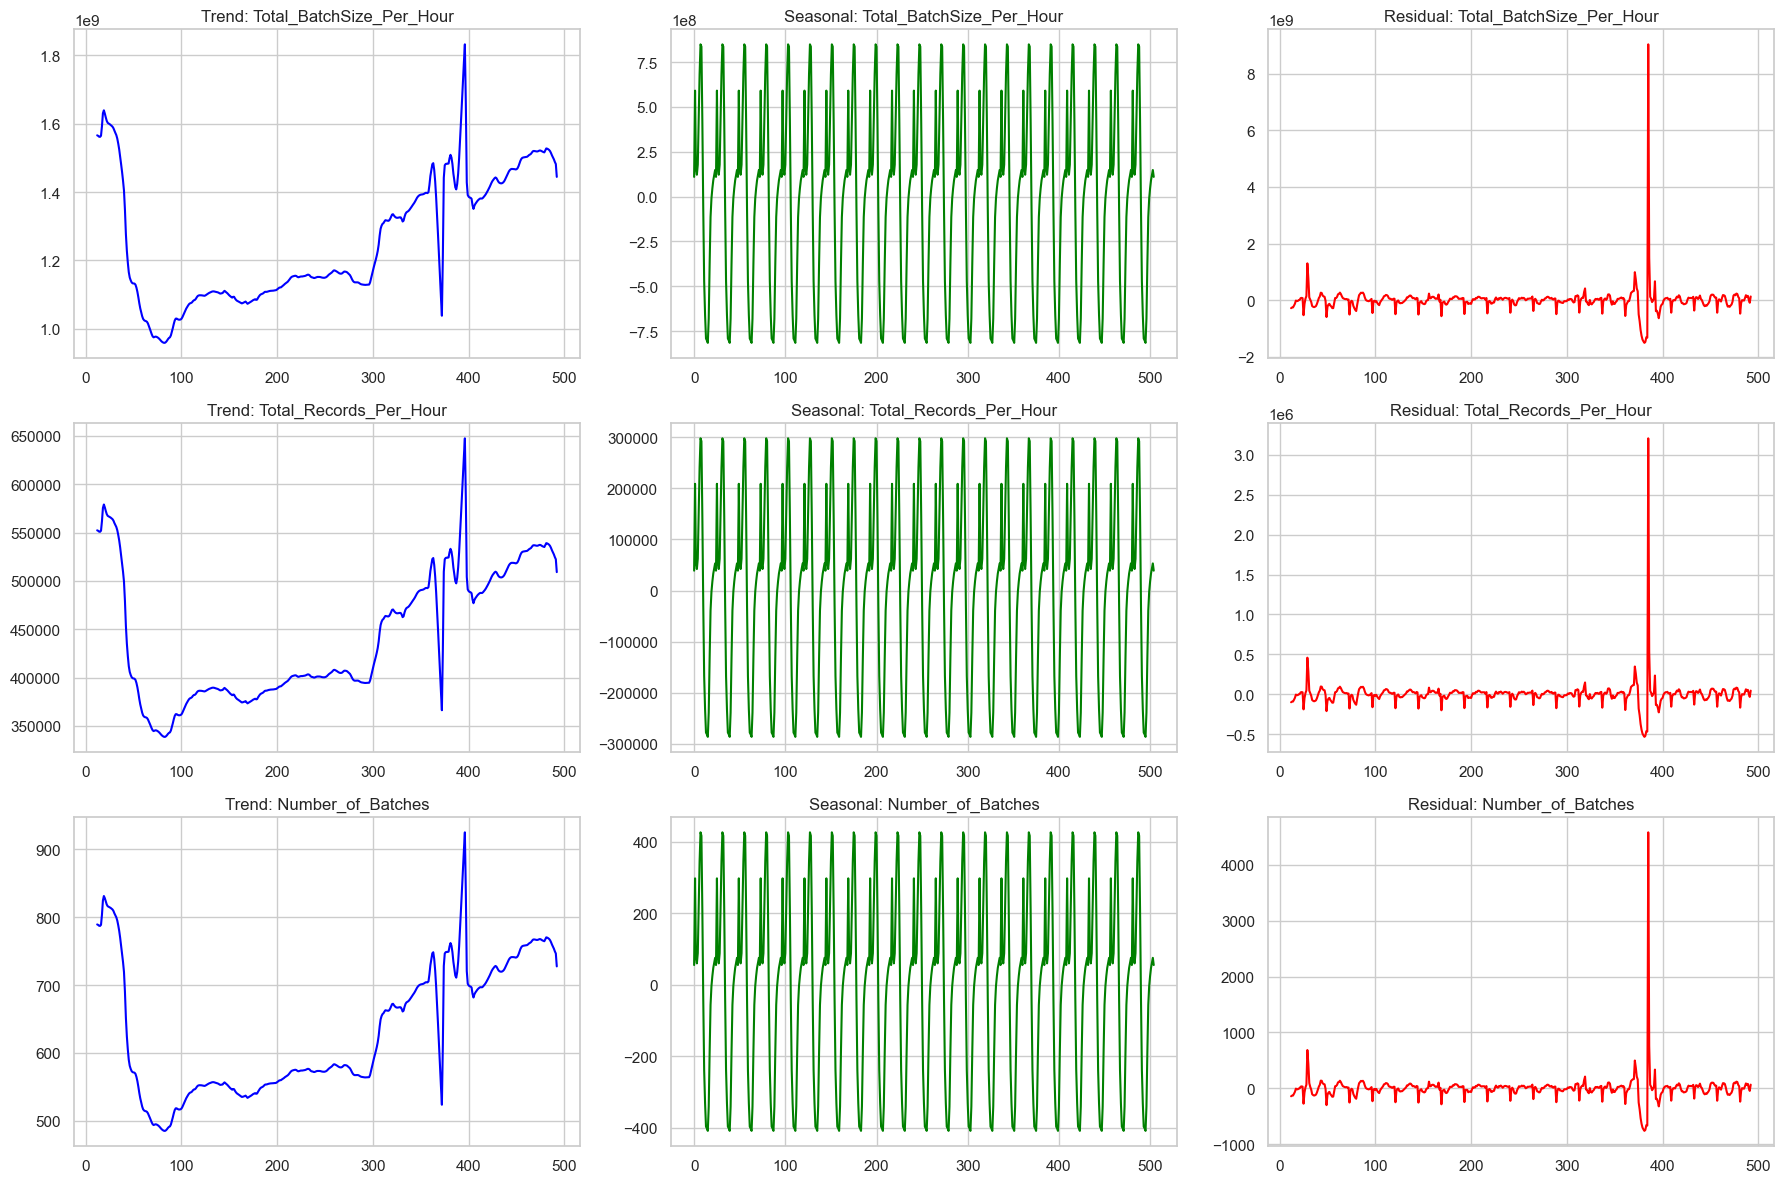





plot fo 443AF5C8-3E45-4F2A-852A-FC2EEE77F72E:




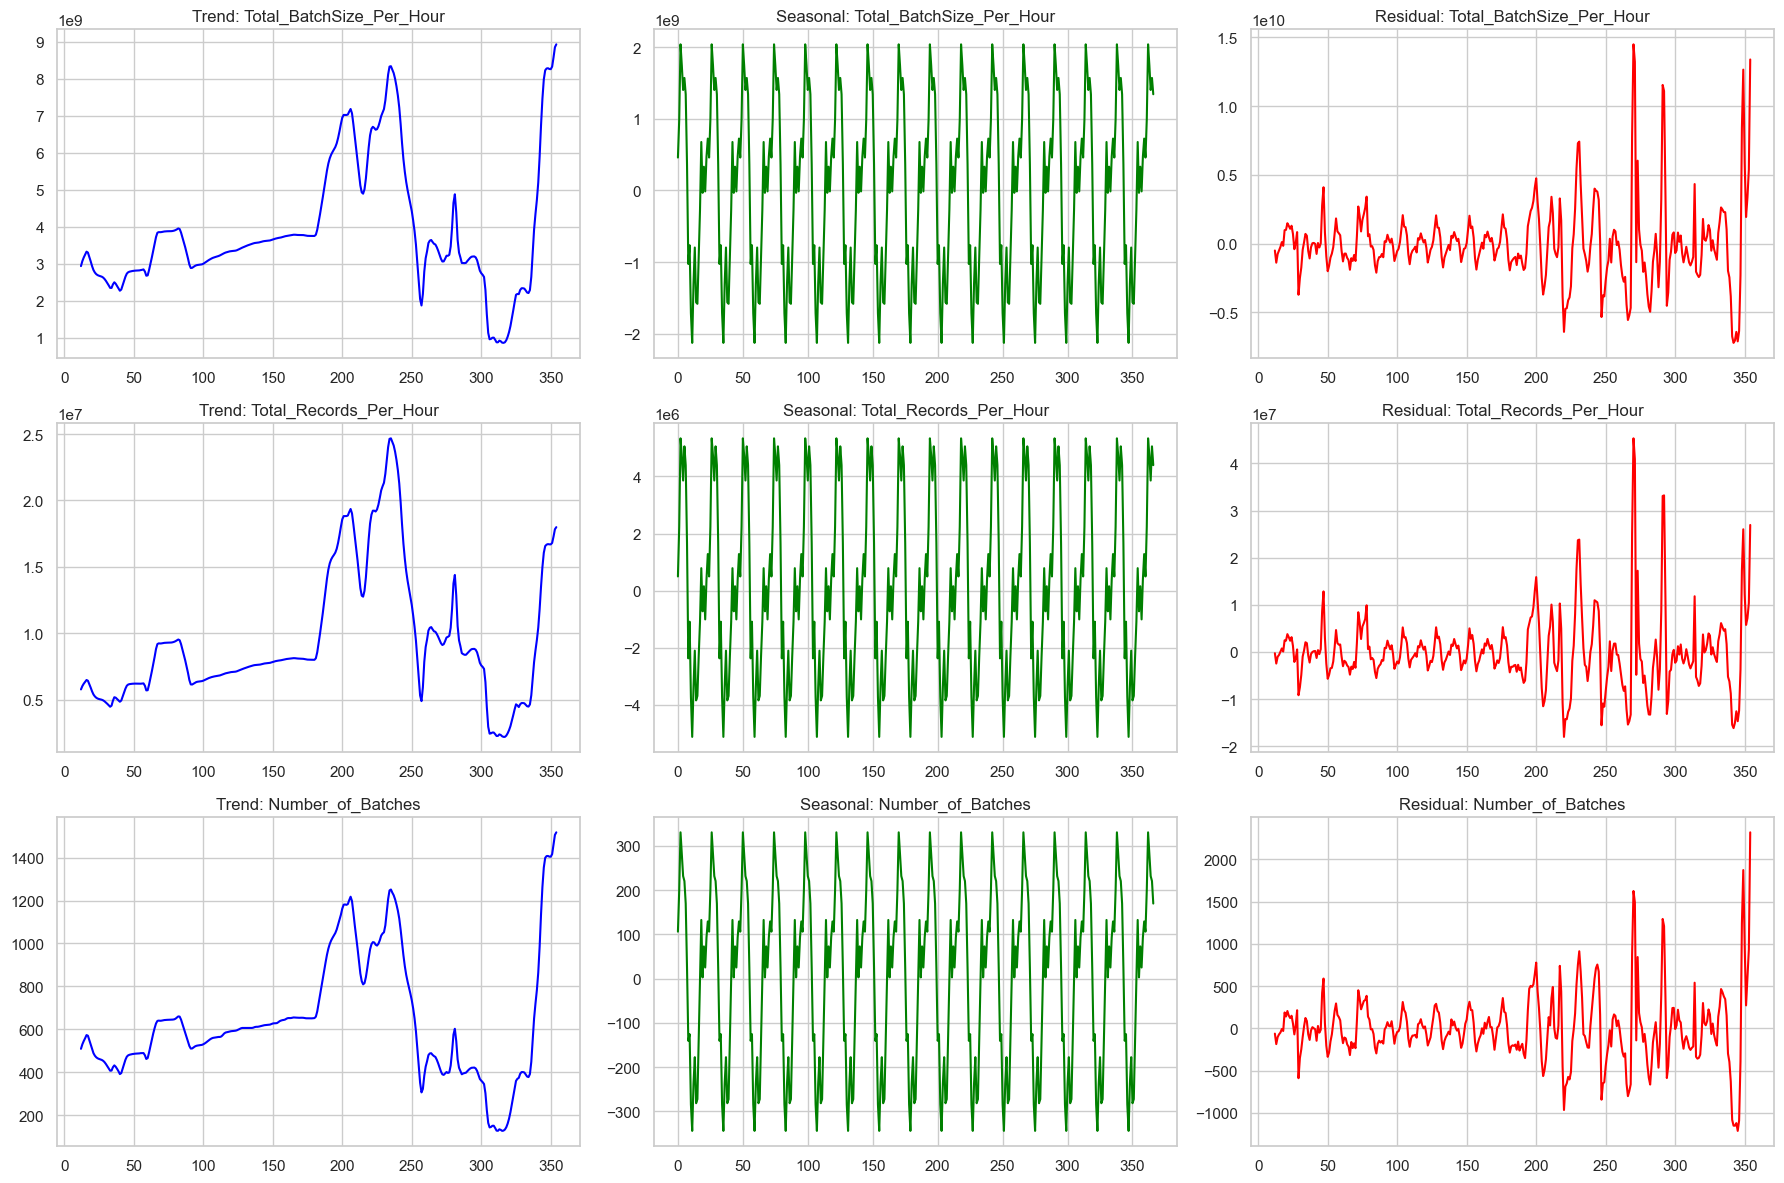





plot fo 45266BBF-196B-4E1C-9ECB-B9E0DFE8ED72:




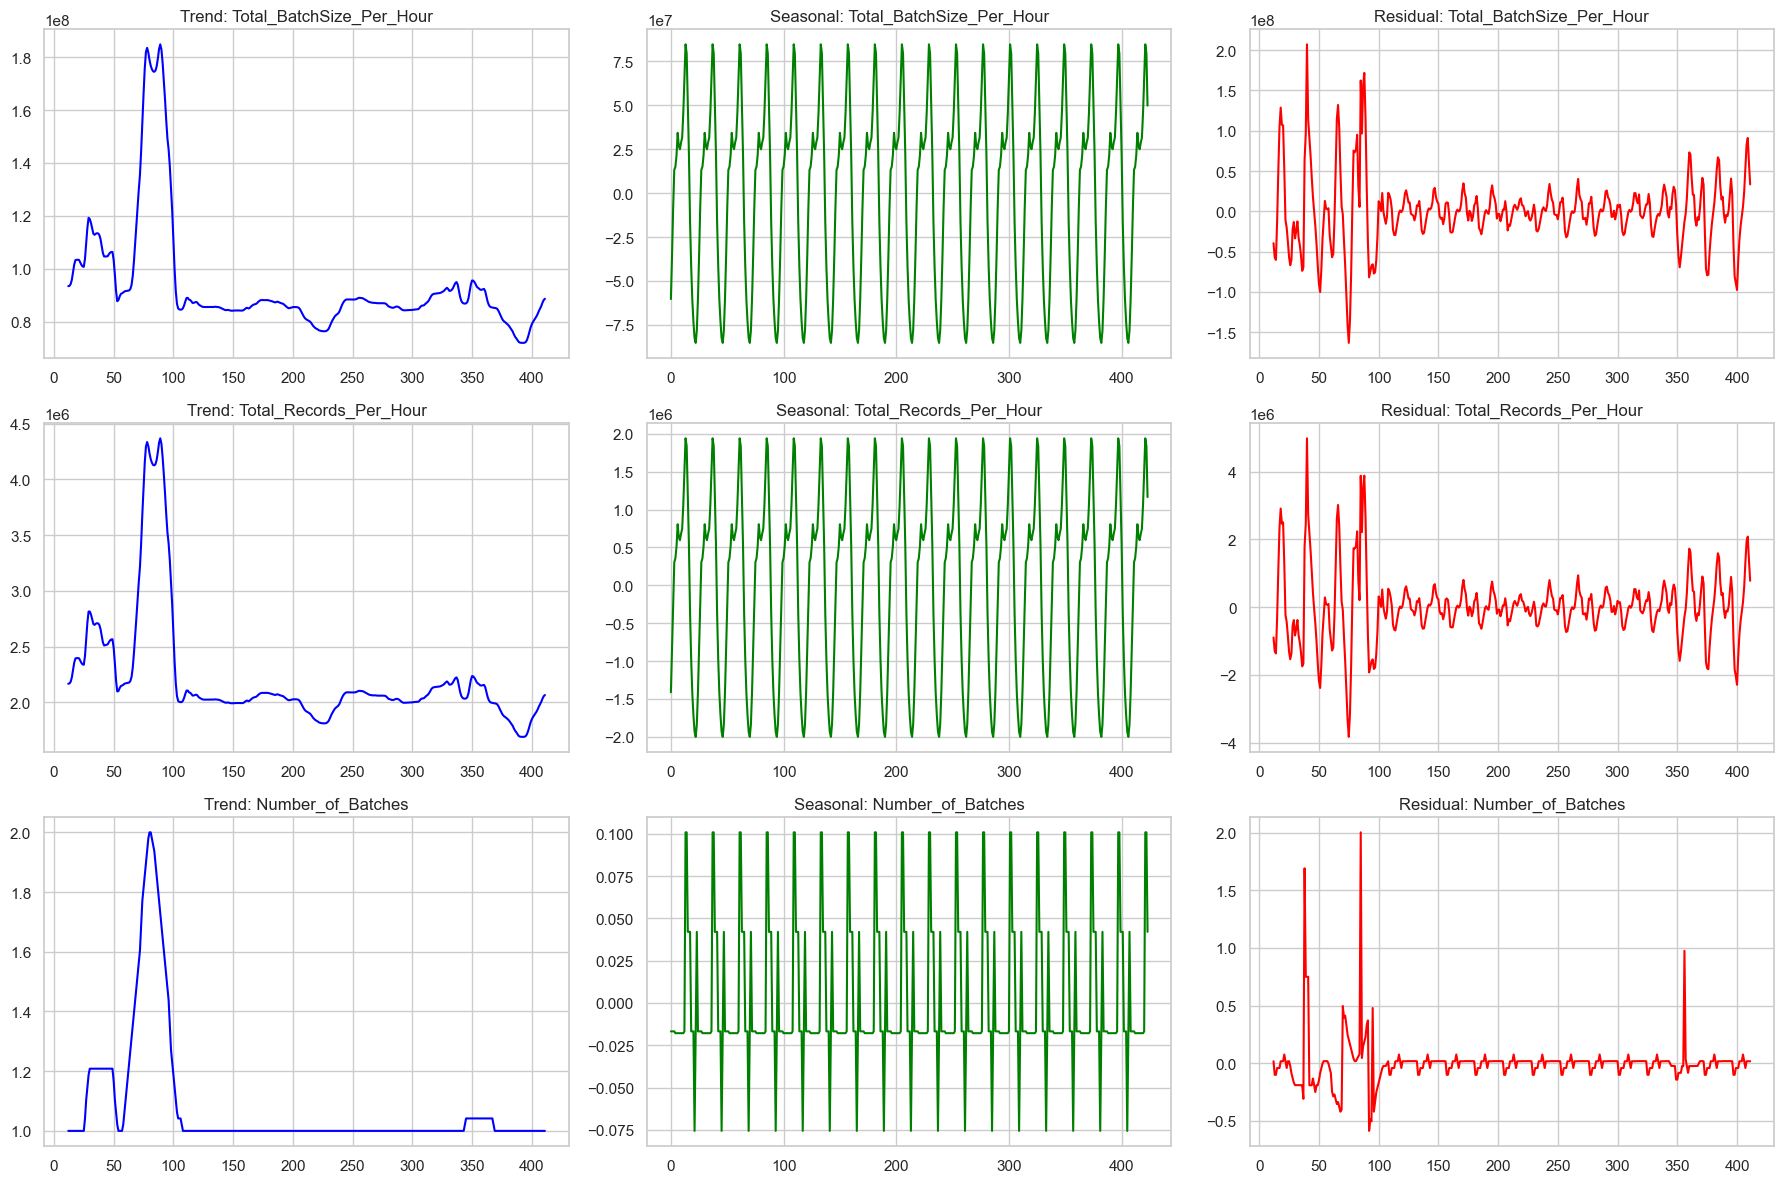





plot fo 52EBB186-CB7C-4E2C-9ABC-2323BB5CE304:




ValueError: x must have 2 complete cycles requires 48 observations. x only has 21 observation(s)

In [59]:
unique_datasource_ids = aggregated_df['DataSourceId'].unique()

for datasource_id in unique_datasource_ids:
    print('\n')
    print(f'plot fo {datasource_id}:')
    print('\n')

    df_filtered = aggregated_df[aggregated_df['DataSourceId'] == datasource_id]
    
    grouped_by_hour = df_filtered.groupby('Date_Hour').agg({
        'Total_BatchSize_Per_Hour': 'sum',
        'Total_Records_Per_Hour': 'sum',
        'Number_of_Batches': 'sum'
    }).reset_index()

    # Perform seasonal decomposition for each feature
    decompose_batch_size = seasonal_decompose(grouped_by_hour['Total_BatchSize_Per_Hour'], model='additive', period=period)
    decompose_records_count = seasonal_decompose(grouped_by_hour['Total_Records_Per_Hour'], model='additive', period=period)
    decompose_batches = seasonal_decompose(grouped_by_hour['Number_of_Batches'], model='additive', period=period)

    # Plot the decomposition results in a 3x3 grid
    plt.figure(figsize=(18, 12))
    
    # Row 1: Total_BatchSize_Per_Hour
    plt.subplot(3, 3, 1)
    plt.plot(decompose_batch_size.trend, color='blue')
    plt.title('Trend: Total_BatchSize_Per_Hour')
    
    plt.subplot(3, 3, 2)
    plt.plot(decompose_batch_size.seasonal, color='green')
    plt.title('Seasonal: Total_BatchSize_Per_Hour')
    
    plt.subplot(3, 3, 3)
    plt.plot(decompose_batch_size.resid, color='red')
    plt.title('Residual: Total_BatchSize_Per_Hour')
    
    # Row 2: Total_Records_Per_Hour
    plt.subplot(3, 3, 4)
    plt.plot(decompose_records_count.trend, color='blue')
    plt.title('Trend: Total_Records_Per_Hour')
    
    plt.subplot(3, 3, 5)
    plt.plot(decompose_records_count.seasonal, color='green')
    plt.title('Seasonal: Total_Records_Per_Hour')
    
    plt.subplot(3, 3, 6)
    plt.plot(decompose_records_count.resid, color='red')
    plt.title('Residual: Total_Records_Per_Hour')
    
    # Row 3: Number_of_Batches
    plt.subplot(3, 3, 7)
    plt.plot(decompose_batches.trend, color='blue')
    plt.title('Trend: Number_of_Batches')
    
    plt.subplot(3, 3, 8)
    plt.plot(decompose_batches.seasonal, color='green')
    plt.title('Seasonal: Number_of_Batches')
    
    plt.subplot(3, 3, 9)
    plt.plot(decompose_batches.resid, color='red')
    plt.title('Residual: Number_of_Batches')
    
    plt.tight_layout()
    plt.show()
    print('\n')


These plots indicate that each DataSourceId exhibits its own distinct trend, with varying fluctuations. None of the trends display consistently stable behavior, such as a clear increase or decrease over time. Additionally, certain plots show unexpected peaks, which could be interpreted as anomalies in the time series.

# Stationarity detection:

In [60]:
from statsmodels.tsa.stattools import adfuller

In [103]:

def test_stationarity(series):
    if series.nunique() <= 1:  
        print("The series is constant; cannot perform ADF test.")
        return False 
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
        return True  
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        return False

In [90]:
aggregated_df['Index_Column'] = aggregated_df.index

df_1 = aggregated_df[[ 'DataSourceId',  'Total_BatchSize_Per_Hour']]

df_1.head()


DataSourceId  \
Date_Hour                                                   
2023-01-25 00:00:00  00BC96FF-4455-430B-99D1-848E1C077597   
2023-01-25 01:00:00  00BC96FF-4455-430B-99D1-848E1C077597   
2023-01-25 02:00:00  00BC96FF-4455-430B-99D1-848E1C077597   
2023-01-25 03:00:00  00BC96FF-4455-430B-99D1-848E1C077597   
2023-01-25 04:00:00  00BC96FF-4455-430B-99D1-848E1C077597   

                     Total_BatchSize_Per_Hour  
Date_Hour                                      
2023-01-25 00:00:00              1.136556e+10  
2023-01-25 01:00:00              2.940523e+06  
2023-01-25 02:00:00              1.910741e+06  
2023-01-25 03:00:00              1.345314e+06  
2023-01-25 04:00:00              1.725078e+06

In [80]:
df_2 = aggregated_df[[ 'DataSourceId',  'Total_Records_Per_Hour']]

df_2.head()


DataSourceId  \
Date_Hour                                                   
2023-01-25 00:00:00  00BC96FF-4455-430B-99D1-848E1C077597   
2023-01-25 01:00:00  00BC96FF-4455-430B-99D1-848E1C077597   
2023-01-25 02:00:00  00BC96FF-4455-430B-99D1-848E1C077597   
2023-01-25 03:00:00  00BC96FF-4455-430B-99D1-848E1C077597   
2023-01-25 04:00:00  00BC96FF-4455-430B-99D1-848E1C077597   

                     Total_Records_Per_Hour  
Date_Hour                                    
2023-01-25 00:00:00                 1512597  
2023-01-25 01:00:00                      63  
2023-01-25 02:00:00                      66  
2023-01-25 03:00:00                      59  
2023-01-25 04:00:00                      70

In [81]:
df_3 = aggregated_df[[ 'DataSourceId',  'Number_of_Batches']]

df_3.head()


DataSourceId  Number_of_Batches
Date_Hour                                                                   
2023-01-25 00:00:00  00BC96FF-4455-430B-99D1-848E1C077597               1275
2023-01-25 01:00:00  00BC96FF-4455-430B-99D1-848E1C077597                 51
2023-01-25 02:00:00  00BC96FF-4455-430B-99D1-848E1C077597                 50
2023-01-25 03:00:00  00BC96FF-4455-430B-99D1-848E1C077597                 44
2023-01-25 04:00:00  00BC96FF-4455-430B-99D1-848E1C077597                 51

## Total_BatchSize_Per_Hour Analysis

In [104]:
grouped = df_1.groupby('DataSourceId')
non_stationary_ids = []

for ds_id, group in grouped:
    print(f"Testing stationarity for DataSourceId: {ds_id}")
    is_stationary = test_stationarity(group['Total_BatchSize_Per_Hour'])
    if not is_stationary:
        non_stationary_ids.append(ds_id)
    print("\n" + "-"*50 + "\n")
    
print(f"Number of non-stationary DataSourceId: {len(non_stationary_ids)}")
print("Non-stationary DataSourceId(s):")

for ds_id in non_stationary_ids:
    print(ds_id)

Testing stationarity for DataSourceId: 00BC96FF-4455-430B-99D1-848E1C077597
ADF Statistics: -10.445873421125038
p- value: 1.4806997969273568e-18
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary

--------------------------------------------------

Testing stationarity for DataSourceId: 070A177E-C632-4F5C-9590-74622E8200BA
ADF Statistics: -8.960566825078223
p- value: 8.246216046835686e-15
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary

--------------------------------------------------

Testing stationarity for DataSourceId: 109697C6-DD94-40CE-92FD-10A0F9559CAC
ADF Statistics: -15.692117065792226
p- value: 1.4296292338279182e-28
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary

--------------------------------------------------

Testing stationarity for DataSourceId: 14033FB5-1C1C-446B-82ED-9ACED6

After Doing the stationarity test, we can detect that there are 2 Datasource Node the represent a nonstationarity. So let's transform them to Stationary.

In [108]:
ds_ids = ['2D5FFF38-04E4-4BA3-9D8D-6AB5484042CA', 'EA093544-861B-4CF6-A87E-9A59928F810A']

subset_df = df_1[df_1['DataSourceId'].isin(ds_ids)]


In [109]:
subset_df

DataSourceId  \
Date_Hour                                                   
2023-01-25 00:00:00  2D5FFF38-04E4-4BA3-9D8D-6AB5484042CA   
2023-01-25 01:00:00  2D5FFF38-04E4-4BA3-9D8D-6AB5484042CA   
2023-01-25 02:00:00  2D5FFF38-04E4-4BA3-9D8D-6AB5484042CA   
2023-01-25 03:00:00  2D5FFF38-04E4-4BA3-9D8D-6AB5484042CA   
2023-01-25 04:00:00  2D5FFF38-04E4-4BA3-9D8D-6AB5484042CA   
...                                                   ...   
2023-02-11 00:00:00  EA093544-861B-4CF6-A87E-9A59928F810A   
2023-02-12 00:00:00  EA093544-861B-4CF6-A87E-9A59928F810A   
2023-02-13 00:00:00  EA093544-861B-4CF6-A87E-9A59928F810A   
2023-02-14 00:00:00  EA093544-861B-4CF6-A87E-9A59928F810A   
2023-02-15 00:00:00  EA093544-861B-4CF6-A87E-9A59928F810A   

                     Total_BatchSize_Per_Hour  
Date_Hour                                      
2023-01-25 00:00:00              3.190093e+09  
2023-01-25 01:00:00              2.203394e+09  
2023-01-25 02:00:00              1.764967e+09  
2023-01-25 03:00:00              1.729391e+09  
2023-01-25 04:00:00              2.432387e+09  
...                                       ...  
2023-02-11 00:00:00              1.341000e+03  
2023-02-12 00:00:00              7.310000e+02  
2023-02-13 00:00:00              8.282000e+03  
2023-02-14 00:00:00              1.457000e+04  
2023-02-15 00:00:00              1.449100e+04  

[464 rows x 2 columns]

In [110]:

from statsmodels.stats.diagnostic import het_arch

non_stationary_ds_ids = []

for ds_id in ds_ids:
    data = subset_df[subset_df['DataSourceId'] == ds_id]
    
    # Apply the ARCH test
    test_statistic, p_value, _, _ = het_arch(data['Total_BatchSize_Per_Hour'].dropna())
    
    print(f'Testing variance stability for DataSourceId: {ds_id}')
    print('ARCH Test Statistic:', test_statistic)
    print('ARCH Test p-value:', p_value)
    
    if p_value < 0.05:
        print("Evidence of heteroscedasticity (non-stable variance).")
        non_stationary_ds_ids.append(ds_id)
    else:
        print("No evidence of heteroscedasticity.")
    print('---')


Testing variance stability for DataSourceId: 2D5FFF38-04E4-4BA3-9D8D-6AB5484042CA
ARCH Test Statistic: 374.4639317672584
ARCH Test p-value: 2.539959040188116e-74
Evidence of heteroscedasticity (non-stable variance).
---
Testing variance stability for DataSourceId: EA093544-861B-4CF6-A87E-9A59928F810A
ARCH Test Statistic: 13.225694629179948
ARCH Test p-value: 0.010224074870631428
Evidence of heteroscedasticity (non-stable variance).
---


We Can do the log treansformation.

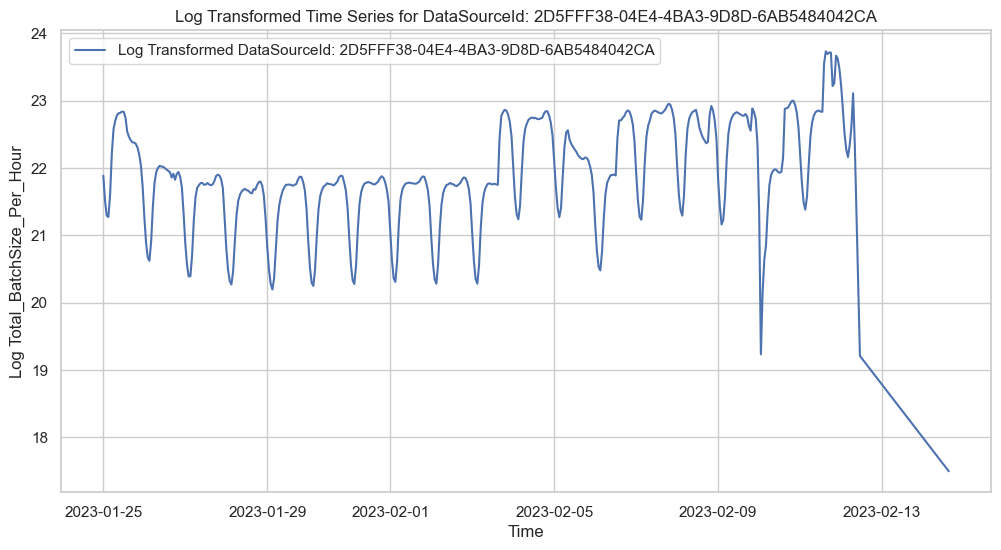

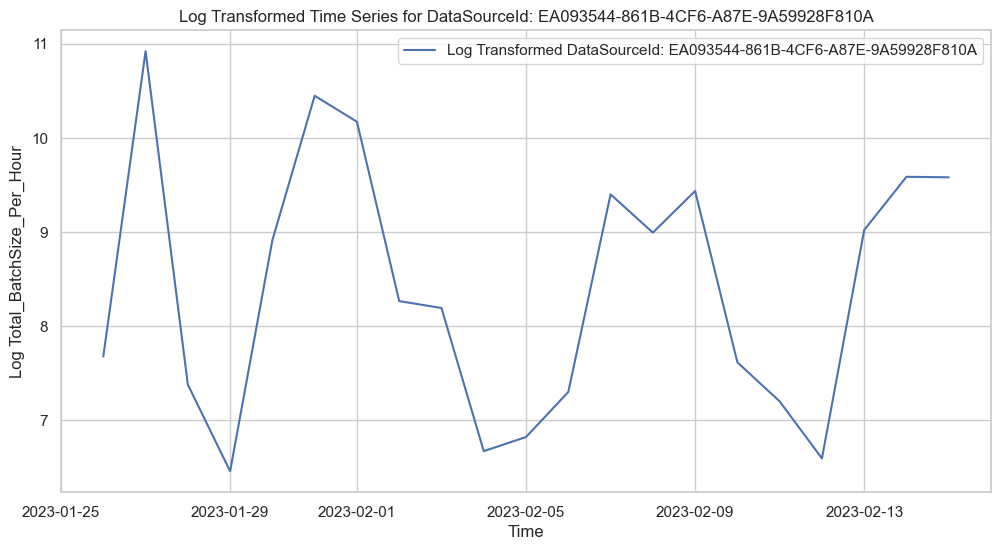

In [111]:
log_transformed_data = {}

for ds_id in ds_ids:
    data = subset_df[subset_df['DataSourceId'] == ds_id].copy()
    
    data['Log_Total_BatchSize_Per_Hour'] = np.log(data['Total_BatchSize_Per_Hour'] + 1)
    
    log_transformed_data[ds_id] = data

    plt.figure(figsize=(12, 6))
    plt.plot(data['Log_Total_BatchSize_Per_Hour'], label=f'Log Transformed DataSourceId: {ds_id}')
    plt.title(f'Log Transformed Time Series for DataSourceId: {ds_id}')
    plt.xlabel('Time')
    plt.ylabel('Log Total_BatchSize_Per_Hour')
    plt.legend()
    plt.show()

## Autocorrelation

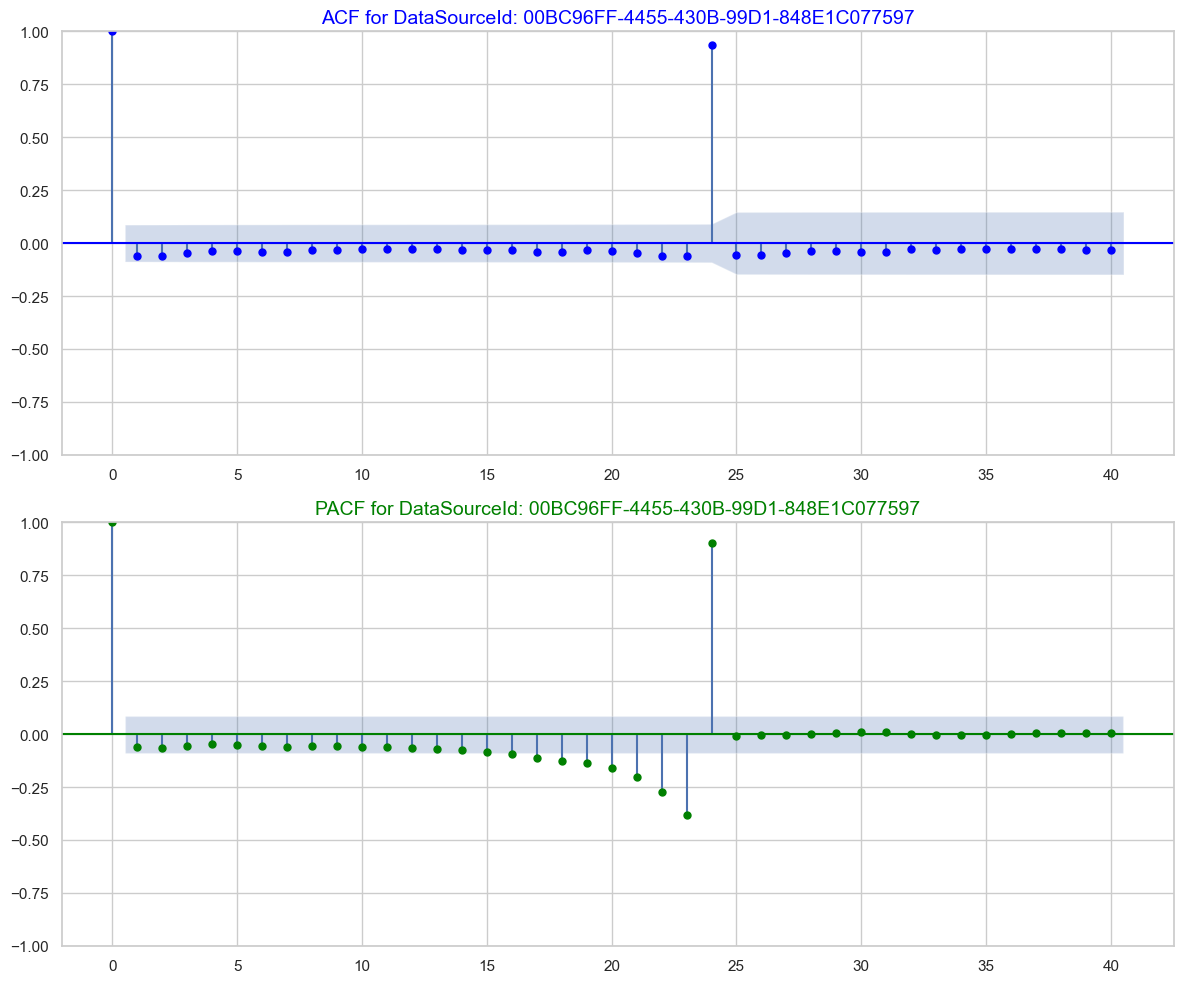

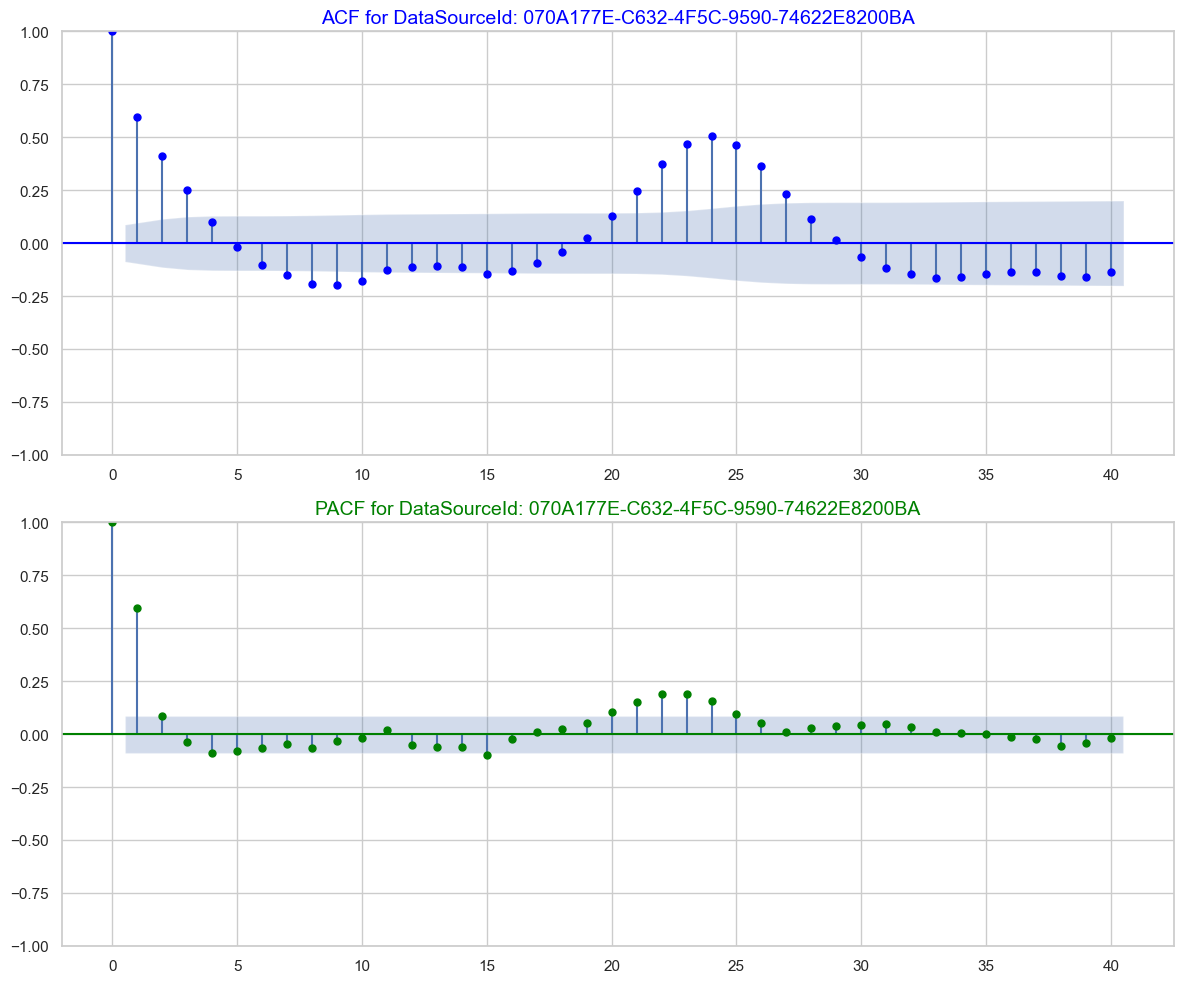

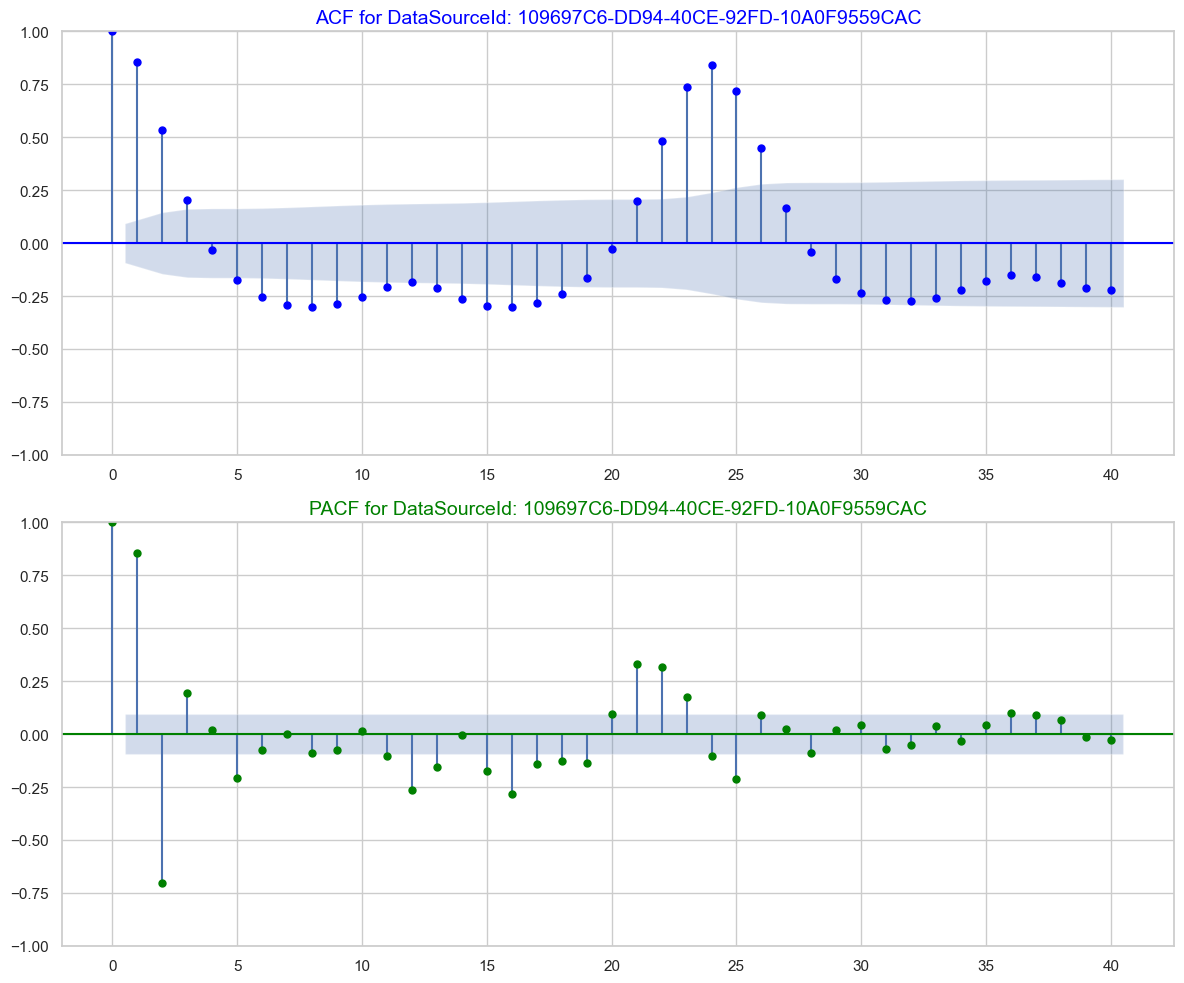

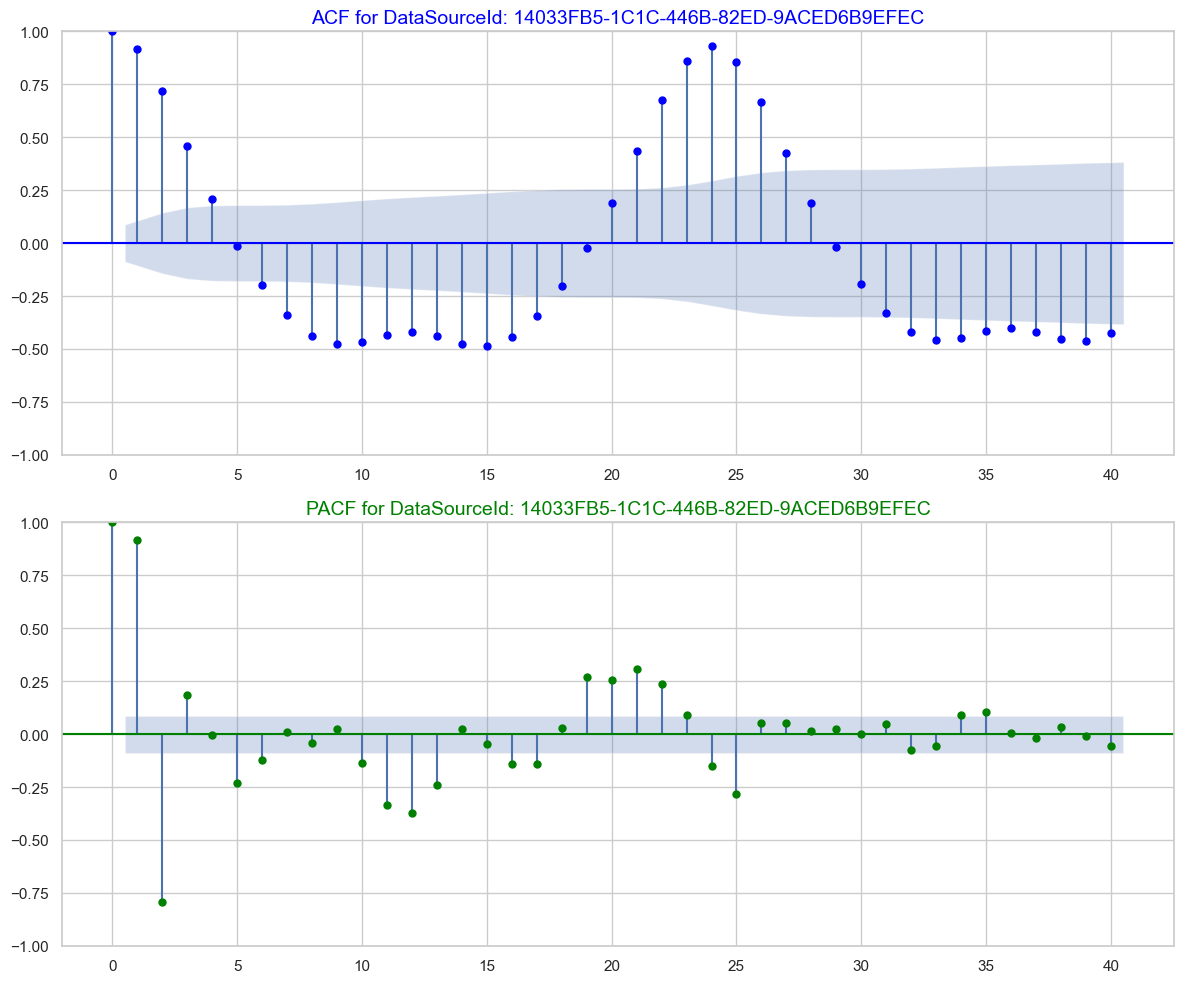

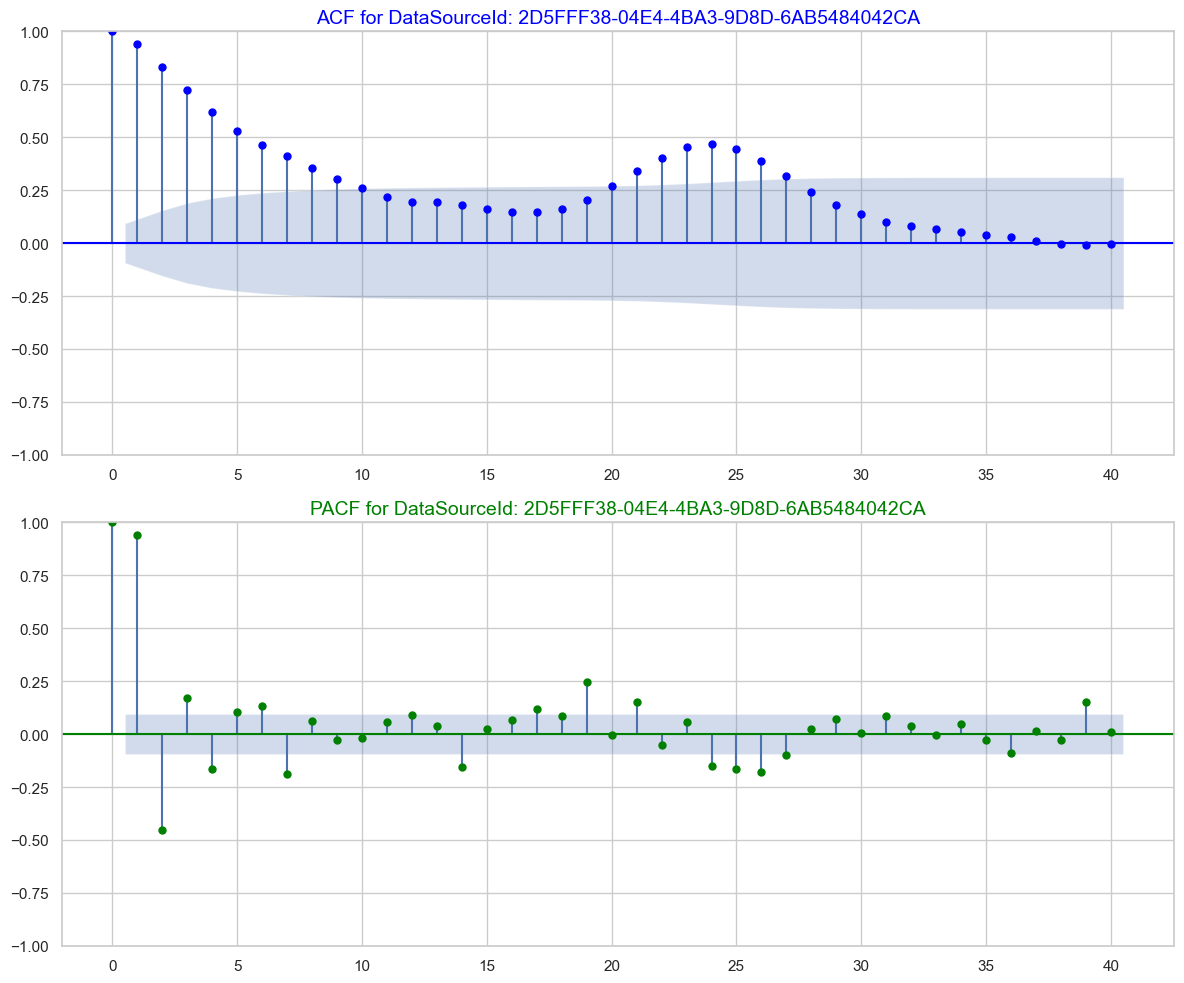

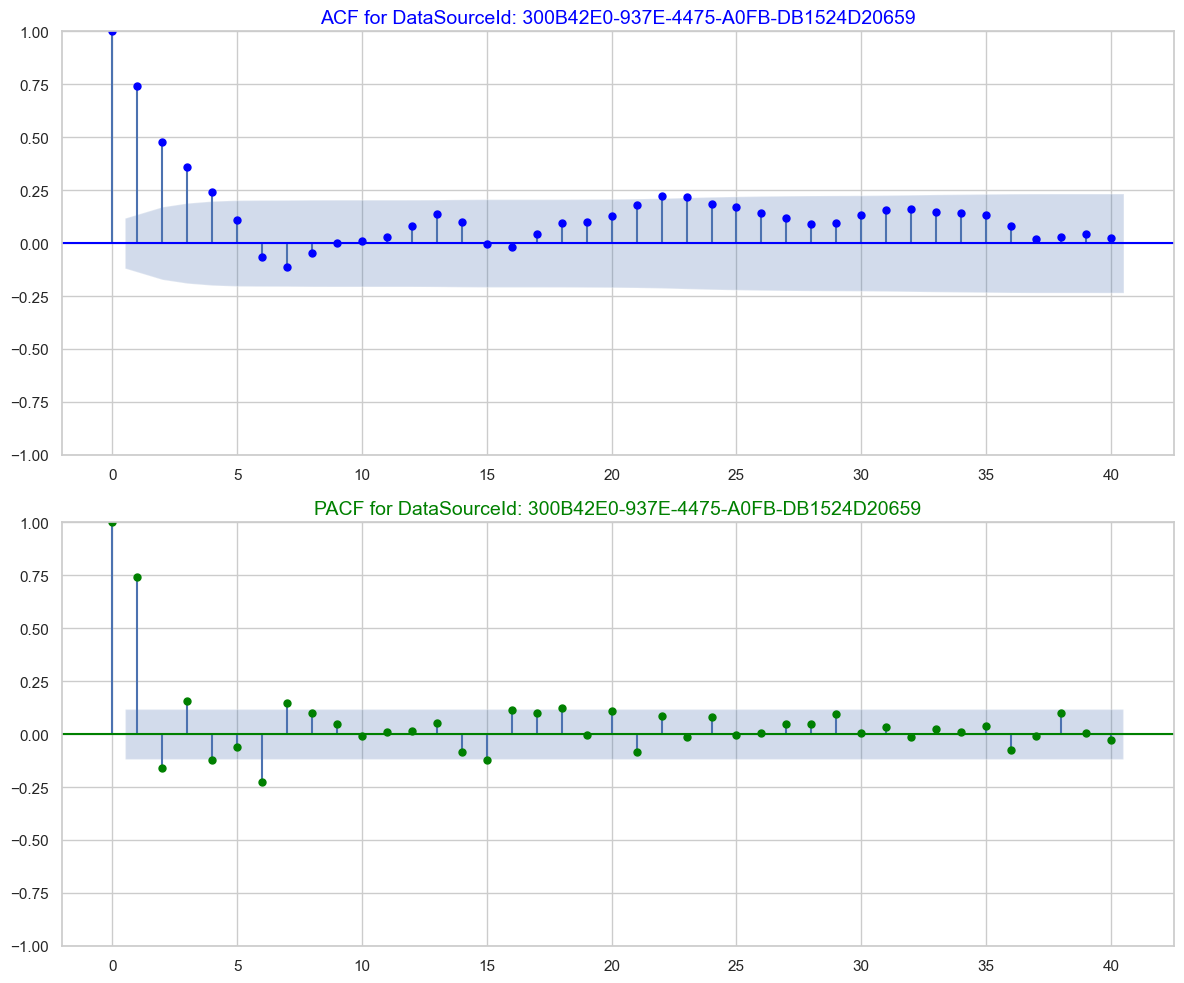

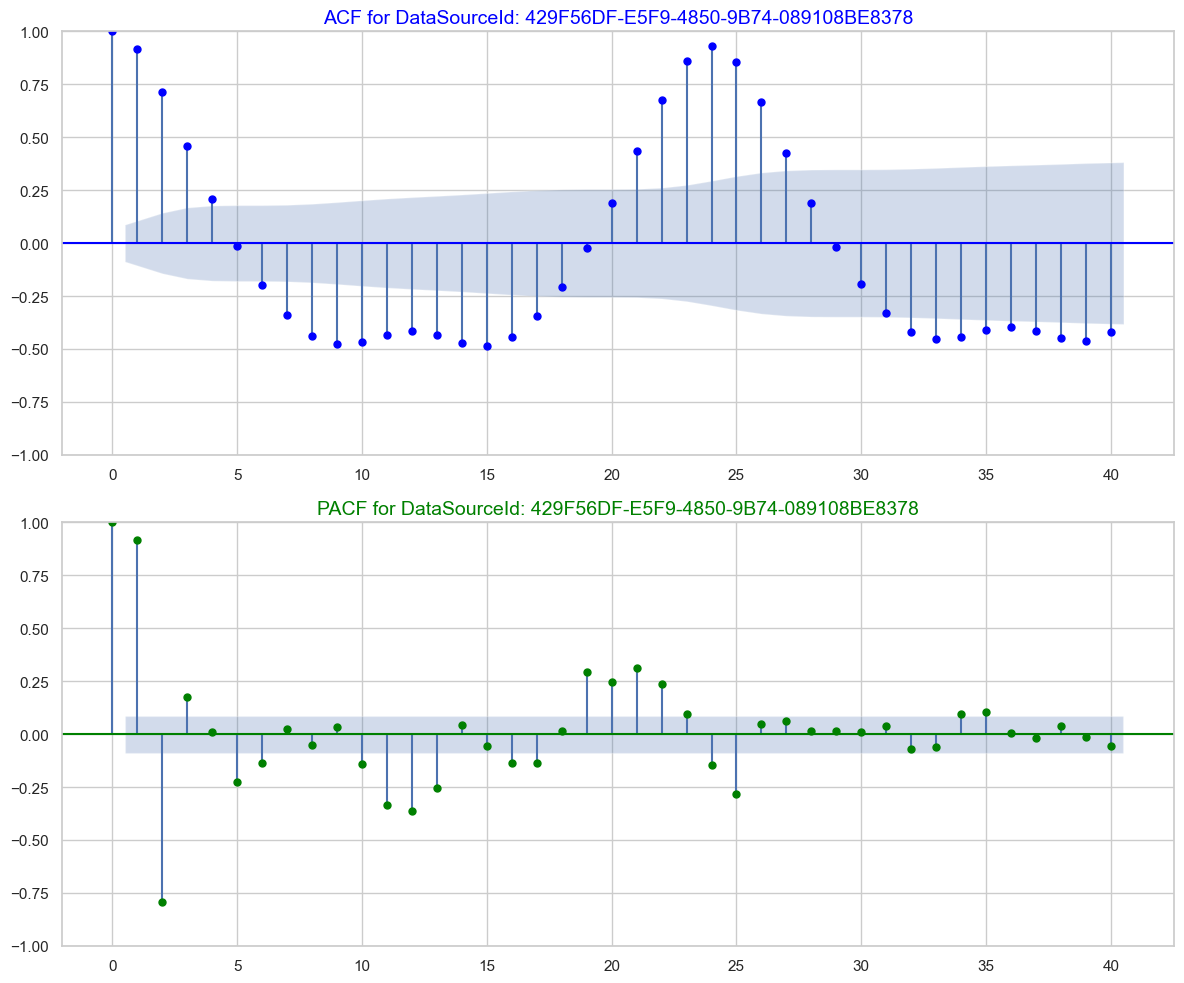

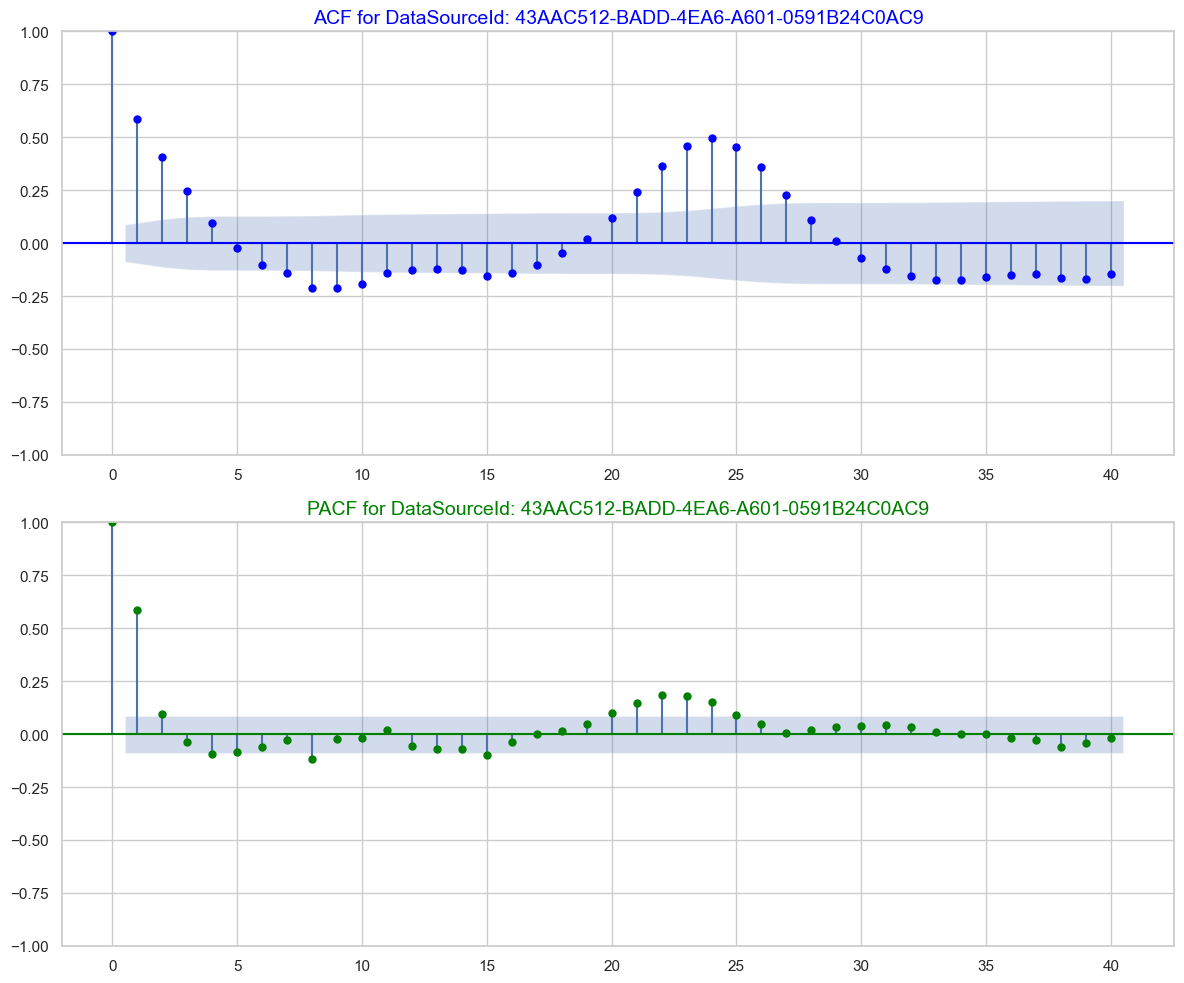

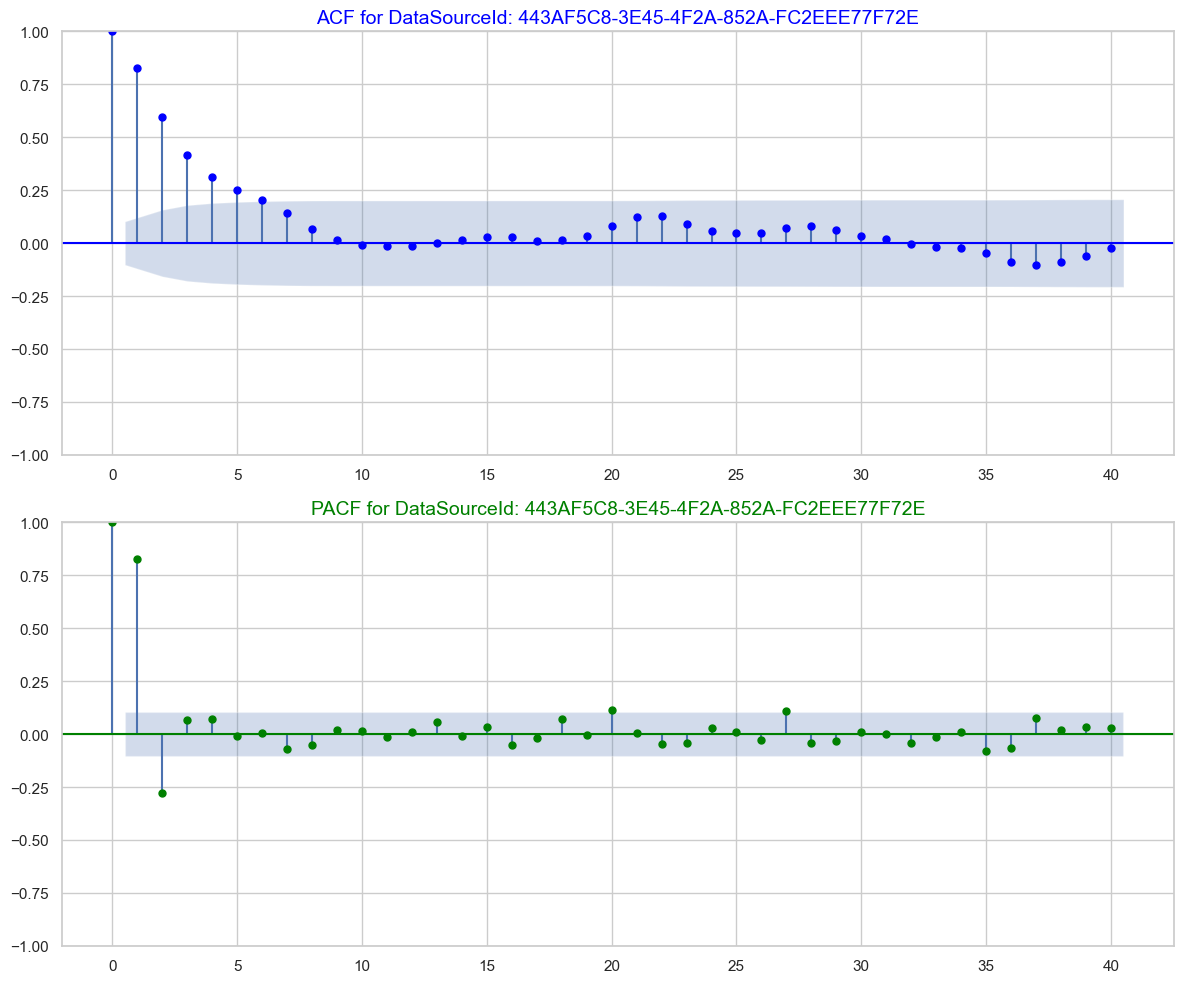

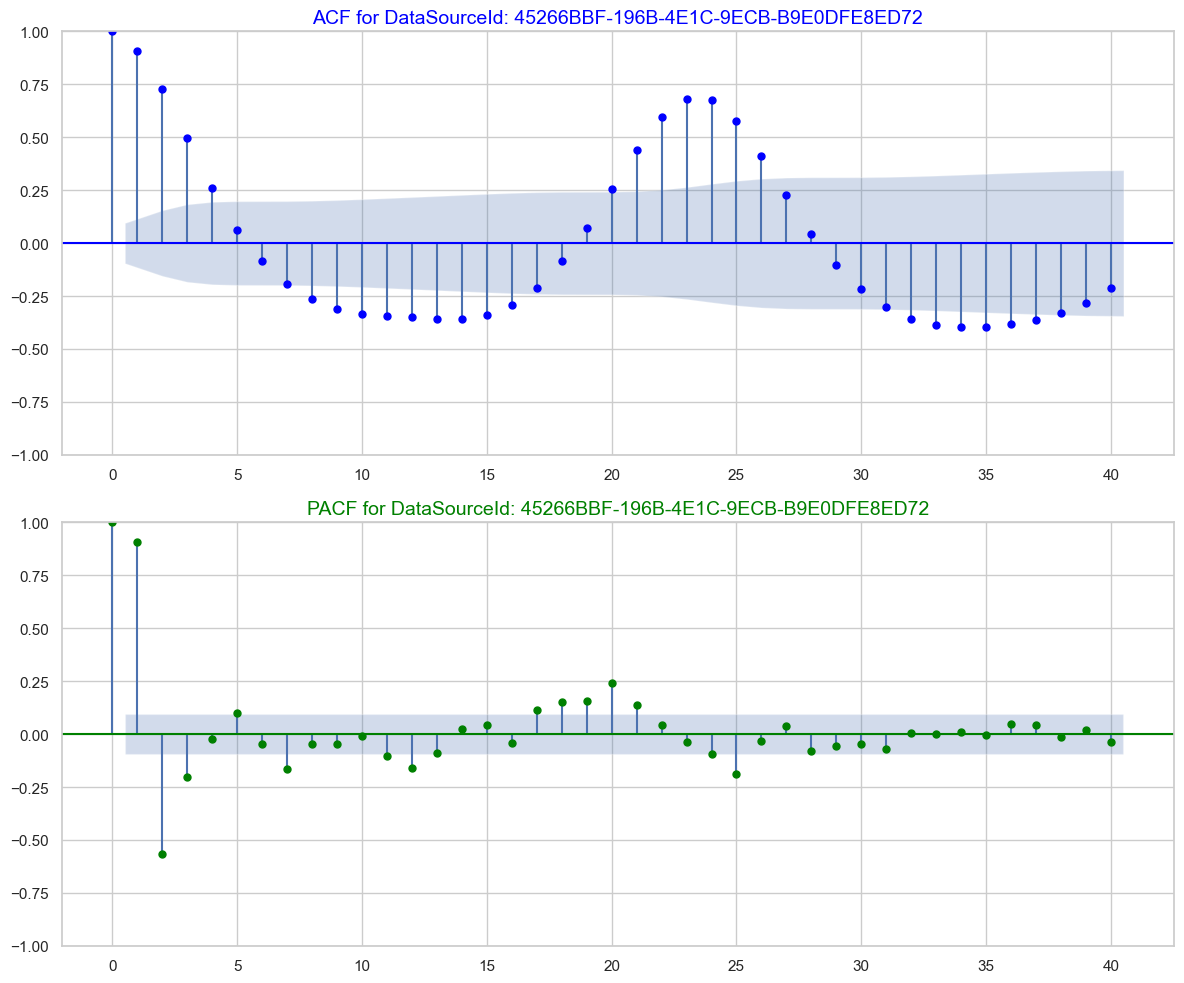

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 10 must be < 10.

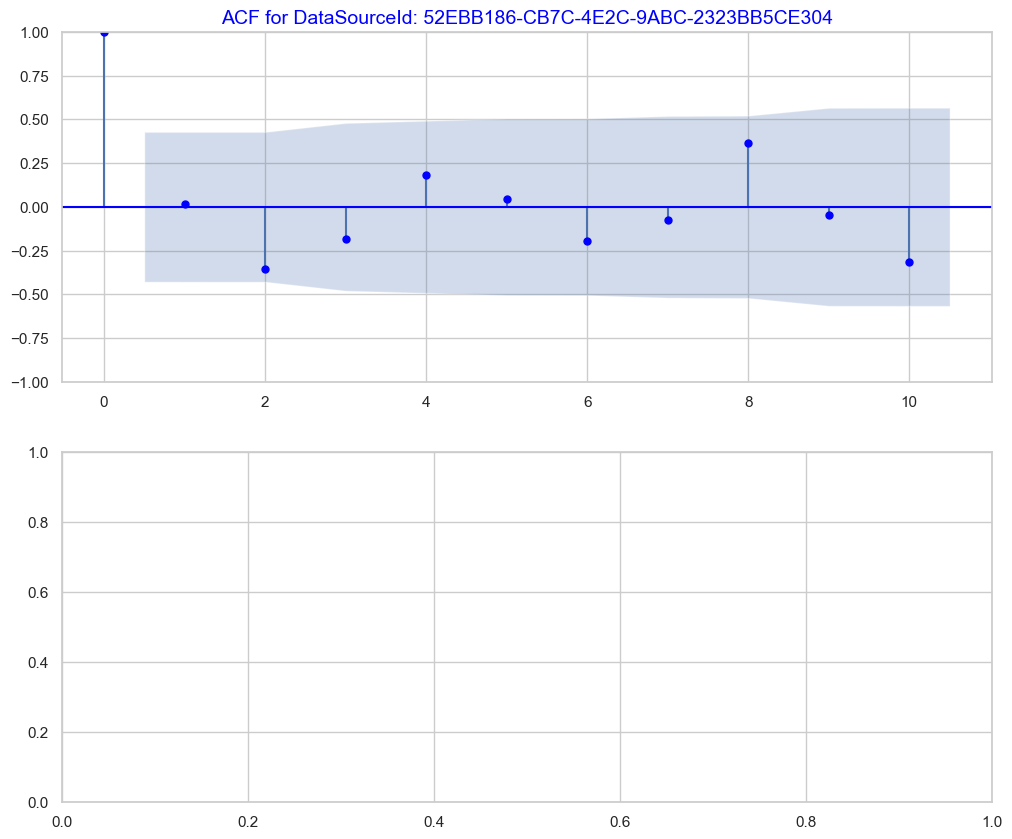

In [119]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_color = 'blue'
pacf_color = 'green'


for ds_id, group in grouped:
    plt.figure(figsize=(12, 10))
    
    n_obs = len(group['Total_BatchSize_Per_Hour'].dropna())
    lags = min(40, n_obs // 2) 
    
    # Plot ACF 
    plt.subplot(2, 1, 1)
    plot_acf(group['Total_BatchSize_Per_Hour'].dropna(), lags=lags, ax=plt.gca(), color=acf_color)
    plt.title(f'ACF for DataSourceId: {ds_id}', fontsize=14, color=acf_color)
    
    # Plot PACF 
    plt.subplot(2, 1, 2)
    plot_pacf(group['Total_BatchSize_Per_Hour'].dropna(), lags=lags, ax=plt.gca(), color=pacf_color)
    plt.title(f'PACF for DataSourceId: {ds_id}', fontsize=14, color=pacf_color)
    
    plt.tight_layout()
    plt.show()


**Plot Analysis**:
</br>
The ACF and PACF plots, which represent the autocorrelation and the relationship between lagged versions of the data, show that some DataSourceId nodes exhibit high correlation at the 24th lag. This could indicate a daily periodicity, as the 24-hour cycle may reflect repeated patterns in the data flow. Other nodes display significant correlation both before and after the 24th lag. This highlights the presence of a dependence in the flow, repeating with similar characteristics. However, some nodes show minimal or no significant correlation with their previous time points, suggesting that the data flow in these nodes does not follow a consistent time-based pattern or dependency.

## Total_Records_Per_Hour Analysis

In [105]:
grouped_2 = df_2.groupby('DataSourceId')
non_stationary_ids_2 = []

for ds_id, group in grouped_2:
    print(f"Testing stationarity for DataSourceId: {ds_id}")
    is_stationary = test_stationarity(group['Total_Records_Per_Hour'])
    if not is_stationary:
        non_stationary_ids_2.append(ds_id)
    print("\n" + "-"*50 + "\n")
    
print(f"Number of non-stationary DataSourceId: {len(non_stationary_ids_2)}")
print("Non-stationary DataSourceId(s):")

for ds_id in non_stationary_ids_2:
    print(ds_id)

Testing stationarity for DataSourceId: 00BC96FF-4455-430B-99D1-848E1C077597
ADF Statistics: -11.572760169847427
p- value: 3.0737667294975947e-21
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary

--------------------------------------------------

Testing stationarity for DataSourceId: 070A177E-C632-4F5C-9590-74622E8200BA
ADF Statistics: -9.004195810828518
p- value: 6.376881479163495e-15
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary

--------------------------------------------------

Testing stationarity for DataSourceId: 109697C6-DD94-40CE-92FD-10A0F9559CAC
ADF Statistics: -11.05643470210028
p- value: 4.931525551837051e-20
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary

--------------------------------------------------

Testing stationarity for DataSourceId: 14033FB5-1C1C-446B-82ED-9ACED6B9

## Number_of_Batches Analysis

In [106]:
grouped_3 = df_3.groupby('DataSourceId')
non_stationary_ids_3 = []

for ds_id, group in grouped_3:
    print(f"Testing stationarity for DataSourceId: {ds_id}")
    is_stationary = test_stationarity(group['Number_of_Batches'])
    if not is_stationary:
        non_stationary_ids_3.append(ds_id)
    print("\n" + "-"*50 + "\n")
    
print(f"Number of non-stationary DataSourceId: {len(non_stationary_ids_3)}")
print("Non-stationary DataSourceId(s):")

for ds_id in non_stationary_ids_3:
    print(ds_id)

Testing stationarity for DataSourceId: 00BC96FF-4455-430B-99D1-848E1C077597
ADF Statistics: -23.18038098853969
p- value: 0.0
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary

--------------------------------------------------

Testing stationarity for DataSourceId: 070A177E-C632-4F5C-9590-74622E8200BA
ADF Statistics: -9.004913737233073
p- value: 6.3499667853946544e-15
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary

--------------------------------------------------

Testing stationarity for DataSourceId: 109697C6-DD94-40CE-92FD-10A0F9559CAC
ADF Statistics: -17.781446813054593
p- value: 3.2757918961768854e-30
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary

--------------------------------------------------

Testing stationarity for DataSourceId: 14033FB5-1C1C-446B-82ED-9ACED6B9EFEC
ADF Statisti